# Intelligent Code Autocompletion with Transformer Models

Welcome to this notebook on leveraging modern language models for code autocompletion — a key component in intelligent developer tools.  
Our focus is on C/C++ source code, particularly in the context of STM32 embedded development, where productivity and correctness are critical.

In this notebook, we walk through the complete pipeline:
- Preparing and structuring code datasets  
- Tokenizing C/C++ source code efficiently  
- Fine-tuning a transformer-based model on domain-specific data  
- Generating high-quality code completions and evaluating their performance

By the end, you'll see how models can learn to predict function bodies, complete control structures, or suggest context-aware snippets — just like an AI coding assistant.

This is a step toward building LLM-based tools that understand and complete real-world firmware code.


# *Data Processing*

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
from huggingface_hub import login
from google.colab import userdata
login(token=userdata.get("HF_TOKEN"))

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import logging
import re
import os

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
# range for loading files
first_file = 300
last_file = 399
if last_file < first_file:
    raise ValueError("last_file must be greater than or equal to first_file")

In [ ]:
def clean_code(code):
    # Remove multi-line comments (/* ... */)
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
    # Remove single-line comments (// ...)
    code = re.sub(r'//.*$', '', code, flags=re.MULTILINE)
    # Remove extra whitespace lines
    code = '\n'.join(line for line in code.splitlines() if line.strip())
    return code

def limit_includes(code, max_includes=5):
    """Keep up to max_includes #include lines, preserve rest of code."""
    lines = code.split('\n')
    include_lines = [line for line in lines if line.strip().startswith('#include')]
    other_lines = [line for line in lines if not line.strip().startswith('#include')]
    # Keep min(max_includes, len(include_lines))
    kept_includes = include_lines[:max_includes]
    # Reassemble: includes first, then rest
    return '\n'.join(kept_includes + other_lines)

# Define STM32-specific keywords (core and optional)
core_stm32_keywords = [r'\bHAL_', r'stm32[fhl][0-7]xx']  # Specific STM32 families
optional_stm32_keywords = ["RCC_", "MX_", "GPIO[A-E]", "SystemClock_Config", "USART[1-6]"]

# C code indicators (keep these)
c_indicators = ["#include <", "int main(", "printf("]

# Non-C exclusions (keep these)
non_c_keywords = ["class ", "@property", "virtual ", "iostream"]

def view_file(file_index, output_dir="stm32_files"):
    """View the content of a specific STM32 file by its index (e.g., stm32_file_60.c)."""
    file_path = os.path.join(output_dir, f"stm32_file_{file_index}.c")
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            content = f.read()
            print(f"Content of stm32_file_{file_index}.c:")
            print(content)
        return content
    else:
        print(f"File stm32_file_{file_index}.c not found in {output_dir}.")
        return None


num_files = last_file - first_file + 1
logger.info(f"Loading {num_files} files from index {first_file} to {last_file}")

# Load dataset
dataset = load_dataset("bigcode/the-stack", data_dir="data/c", split="train", streaming=True, trust_remote_code=True)

# Process files
stm32_files = []
count = 0

for sample in dataset:
    try:
        content = sample["content"]
        ext = sample.get("ext", "").lower()
        cleaned_content = clean_code(content)
        if (ext == "c" and
            any(kw in cleaned_content for kw in c_indicators) and
            all(kw not in cleaned_content for kw in non_c_keywords) and
            any(re.search(kw, cleaned_content, re.IGNORECASE) for kw in core_stm32_keywords) and
            any(re.search(kw, cleaned_content, re.IGNORECASE) for kw in optional_stm32_keywords)):
            if count >= first_file and count <= last_file:
                limited_content = limit_includes(cleaned_content)
                stm32_files.append(limited_content)
                # Save to disk for view_file
                os.makedirs("stm32_files", exist_ok=True)
                file_path = os.path.join("stm32_files", f"stm32_file_{count}.c")
                with open(file_path, "w", encoding="utf-8") as f:
                    f.write(limited_content)
                logger.info(f"Collected stm32_file_{count}")
            count += 1
            if len(stm32_files) >= num_files:
                break
    except (KeyError, TypeError, AttributeError) as e:
        logger.warning(f"Skipping malformed sample: {e}")
        continue

print(f"Found {len(stm32_files)} STM32-related C files")

README.md:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/257 [00:00<?, ?it/s]

Found 100 STM32-related C files


In [ ]:
view_file(323)

Content of stm32_file_323.c:
#include "esp8266.h"
#include "stm32f4xx_dma.h"
#include "stm32f4xx_usart.h"
#include <string.h>
#include <stdlib.h>
#define MAXACCESSPOINTS 15
static void processAccessPointLine(char *line);
static bool performCommand(const char *cmd, lineProcessor lineProcessor);
static void writeLine(const char *line);
static void readLine(char *line);
static void putch(char);
static char getch(void);
static void readIpd(char c, circBuf_t *dataBuffer);
static void GPIOInitialize(void);
static void UART_Initialize(void);
static void DMA_Initialize(void);
uint16_t receiveBufferTail;
volatile char receiveBuffer[RECEIVE_BUFFER_SIZE];
static char command[64];
static unsigned char amountOfAccessPoints;
static struct AccessPoint accessPoints[MAXACCESSPOINTS];
void esp8266_init(void) {
	GPIOInitialize();
	UART_Initialize();
	DMA_Initialize();
}
static void GPIOInitialize(void) {
	GPIO_InitTypeDef GPIOD_InitStruct;
	RCC_AHB1PeriphClockCmd(RCC_AHB1Periph_GPIOD, ENABLE); 
	GPIOD_In

'#include "esp8266.h"\n#include "stm32f4xx_dma.h"\n#include "stm32f4xx_usart.h"\n#include <string.h>\n#include <stdlib.h>\n#define MAXACCESSPOINTS 15\nstatic void processAccessPointLine(char *line);\nstatic bool performCommand(const char *cmd, lineProcessor lineProcessor);\nstatic void writeLine(const char *line);\nstatic void readLine(char *line);\nstatic void putch(char);\nstatic char getch(void);\nstatic void readIpd(char c, circBuf_t *dataBuffer);\nstatic void GPIOInitialize(void);\nstatic void UART_Initialize(void);\nstatic void DMA_Initialize(void);\nuint16_t receiveBufferTail;\nvolatile char receiveBuffer[RECEIVE_BUFFER_SIZE];\nstatic char command[64];\nstatic unsigned char amountOfAccessPoints;\nstatic struct AccessPoint accessPoints[MAXACCESSPOINTS];\nvoid esp8266_init(void) {\n\tGPIOInitialize();\n\tUART_Initialize();\n\tDMA_Initialize();\n}\nstatic void GPIOInitialize(void) {\n\tGPIO_InitTypeDef GPIOD_InitStruct;\n\tRCC_AHB1PeriphClockCmd(RCC_AHB1Periph_GPIOD, ENABLE); \n\tG

# *Initial idea : LLM reranker for snippet suggestions*

In [ ]:
pip install tree_sitter


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.6/575.6 kB 9.8 MB/s eta 0:00:00


In [ ]:
# 1) Install Universal Ctags & pandas
!apt-get update -qq && apt-get install -y -qq universal-ctags
!pip install --quiet pandas

# 2) Locate & load your STM32 function CSV
import glob, os, pandas as pd
candidates = glob.glob('/mnt/data/stm32_function_descriptions.csv') + glob.glob('/content/stm32_function_descriptions.csv')
if not candidates:
    raise FileNotFoundError("stm32_function_descriptions.csv not found")
csv_path = candidates[0]
print("Loading CSV from:", csv_path)
df = pd.read_csv(csv_path)

# 3) Dump each snippet into a real .c file
SRC = '/content/stm32_src'
os.makedirs(SRC, exist_ok=True)
for _, row in df.iterrows():
    fname = row['file_name']
    if not fname.endswith('.c'):
        fname += '.c'
    with open(os.path.join(SRC, fname), 'w') as f:
        f.write(row['function_code'])
print(f"Wrote {len(df)} files to {SRC}")

# 4) Run ctags to index functions/macros/typedefs/structs/enums
TAGS = '/content/stm32.tags'
!ctags -R --languages=C --fields=+K+n --kinds-C=+p --extras=+q -f {TAGS} {SRC}
print("Generated tags at", TAGS)

# 5) Parse ctags → list of functions
import json
symbols = []
with open(TAGS) as f:
    for line in f:
        if line.startswith('!_TAG'): continue
        parts = line.rstrip('\n').split('\t')
        if len(parts) < 4: continue
        name, _, _, *rest = parts
        sig = ''
        for tok in rest:
            if tok.startswith('signature:'):
                sig = tok.split(':',1)[1]
        symbols.append({'name': name, 'signature': sig})
print(f"Parsed {len(symbols)} symbol entries")

# 6) Build snippet index: every non-empty, non-comment line in your .c files
snippets = set()
for fn in os.listdir(SRC):
    path = os.path.join(SRC, fn)
    with open(path) as f:
        for raw in f:
            line = raw.rstrip()
            stripped = line.strip()
            if not stripped: continue
            if stripped.startswith('//'): continue
            # skip lone braces
            if stripped in ('{','}'): continue
            snippets.add(stripped)
snippets = sorted(snippets)
print(f"Collected {len(snippets)} unique snippet lines")

# 7) Save symbol + snippet table
OUT = '/content/symbol_table.json'
with open(OUT,'w') as f:
    json.dump({'symbols': symbols, 'snippets': snippets}, f)
print("Saved combined index to", OUT)

# 8) REPL: suggest both functions and snippets
import readline
print("\n🔍 Type a prefix (or 'exit'):\n")

def suggest_all(pref, N=5):
    sym_matches = [s for s in symbols if s['name'].startswith(pref)][:N]
    snip_matches = [sn for sn in snippets if sn.startswith(pref)][:N]
    return sym_matches, snip_matches

try:
    while True:
        p = input(">>> ").strip()
        if p.lower() in ('exit','quit'): break

        syms, snaps = suggest_all(p)
        if not syms and not snaps:
            print("  (no matches)\n")
            continue

        if syms:
            print("  Functions:")
            for s in syms:
                print(f"    {s['name']:30}{s['signature']}")
        if snaps:
            print("  Snippets:")
            for s in snaps:
                print(f"    {s}")
        print()

except KeyboardInterrupt:
    print("\n👋 Goodbye!")


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Loading CSV from: /content/stm32_function_descriptions.csv
Wrote 2079 files to /content/stm32_src
Generated tags at /content/stm32.tags
Parsed 15503 symbol entries
Collected 31126 unique snippet lines
Saved combined index to /content/symbol_table.json

🔍 Type a prefix (or 'exit'):

>>> while
  Snippets:
    while ( (HAL_GetTick() - start_time_ms) < delay_ms)
    while ( 1 )
    while (!(CDC_Transmit_FS((uint8_t *)&ch, 1) == USBD_BUSY))
    while (!(CDC_Transmit_FS((uint8_t *)&ch, 1) == USBD_OK))
    while (!(USART2->SR & USART_SR_TC))

>>> if
  Snippets:
    if ( !timer ) state = STATE_BENCHMARK_RESULT;
    if ( ( b >= 97 ) && ( b <= 122 ) ) {
    if ( (angle >  180) || (angle < 0)) {
    if ( (duty < 0) && (period >= -duty) )
    if ( (duty > 0) && (period >= duty) )

>>> hal
  Functions:
    hal_bs

In [ ]:
import readline
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

print("\n🔍 Type a prefix (or 'exit'):\n")

# Function to suggest matches based on prefix
def suggest_all(pref, N=5):
    sym_matches = [s for s in symbols if s['name'].startswith(pref)][:N]
    snip_matches = [sn for sn in snippets if sn.startswith(pref)][:N]
    return sym_matches, snip_matches

# Load the smaller model: distilgpt2
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# LLM reranker function (unchanged logic, just using the new model)
def rerank_with_llm(prefix, functions, snippets):
    # Combine candidates
    candidates = [(f"{s['name']} {s['signature']}", s) for s in functions] + [(sn, sn) for sn in snippets]
    scores = []

    # Score each candidate using the model's log probability
    for cand_str, original in candidates:
        inputs = tokenizer(cand_str, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs['input_ids'])
            loss = outputs.loss
            score = -loss.item()  # Higher score means more likely
        scores.append((cand_str, score, original))

    # Sort by score descending
    scores.sort(key=lambda x: x[1], reverse=True)

    # Separate back into functions and snippets
    reranked_functions = []
    reranked_snippets = []
    for _, score, original in scores:
        if isinstance(original, dict):  # Function
            reranked_functions.append(original)
        else:  # Snippet
            reranked_snippets.append(original)

    return reranked_functions, reranked_snippets

# REPL loop
try:
    while True:
        p = input(">>> ").strip()
        if p.lower() in ('exit', 'quit'):
            break

        # Step 8: Suggest both functions and snippets + call LLM reranker
        syms, snaps = suggest_all(p)
        if not syms and not snaps:
            print("  (no matches)\n")
            continue

        # Display initial suggestions
        if syms:
            print("  Functions:")
            for s in syms:
                print(f"    {s['name']:30}{s['signature']}")
        if snaps:
            print("  Snippets:")
            for s in snaps:
                print(f"    {s}")
        print()

        # Rerank with LLM if there are multiple matches
        total_matches = len(syms) + len(snaps)
        if total_matches > 1:
            reranked_syms, reranked_snaps = rerank_with_llm(p, syms, snaps)
            print("\n✨ LLM Reranked Suggestions:")
            if reranked_syms:
                print("  Functions:")
                for s in reranked_syms:
                    print(f"    {s['name']:30}{s['signature']}")
            if reranked_snaps:
                print("  Snippets:")
                for s in reranked_snaps:
                    print(f"    {s}")
            print()

except KeyboardInterrupt:
    print("\n👋 Goodbye!")


🔍 Type a prefix (or 'exit'):



tokenizer_config.json:   100%|██████████| 0.26.0/26.0 [00:00<?, ?B/s]

config.json:   100%|██████████| 762/762 [00:00<?, ?B/s]

vocab.json:   100%|██████████| 1.04M/1.04M [00:00<?, ?B/s]

merges.txt:   100%|██████████| 456k/456k [00:00<?, ?B/s]

tokenizer.json:   100%|██████████| 1.36/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   100%|██████████| 353M/353M [00:00<?, ?B/s]

generation_config.json:   100%|██████████| 124/124 [00:00<?, ?B/s]

>>> hal
  Functions:
    hal_bsp_core_dump             
    hal_bsp_flash_dev             
    hal_bsp_get_nvic_priority     
    hal_bsp_init                  
    hal_reboot                    
  Snippets:
    halInit();
    hal_bsp_core_dump(int *area_cnt)
    hal_bsp_flash_dev(uint8_t id)
    hal_bsp_get_nvic_priority(int irq_num, uint32_t pri)
    hal_bsp_init(void)



`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.



✨ LLM Reranked Suggestions:
  Functions:
    hal_bsp_flash_dev             
    hal_bsp_get_nvic_priority     
    hal_bsp_core_dump             
    hal_reboot                    
    hal_bsp_init                  
  Snippets:
    hal_bsp_flash_dev(uint8_t id)
    hal_bsp_get_nvic_priority(int irq_num, uint32_t pri)
    hal_bsp_core_dump(int *area_cnt)
    hal_bsp_init(void)
    halInit();

>>> pr
  Functions:
    pressfrac                     
    pressure                      
    pressure                      
    prev_idx                      
    prev_num_samples              
  Snippets:
    pr = (data[0] * 256 + data[1]) >> 6;
    preRangeVcselPeriod = 18;
    pre_time = millis();
    pre_time = reset_time;
    pre_time = rtcReadBackupData(RTC_CFG_DATA_2);


✨ LLM Reranked Suggestions:
  Functions:
    prev_num_samples              
    prev_idx                      
    pressure                      
    pressure                      
    pressfrac                     
  Snip

In [ ]:
import glob
import pandas as pd
import re

# 1) Locate & load your STM32 function CSV (Colab path)
csv_path = '/content/stm32_function_descriptions.csv'
df = pd.read_csv(csv_path)

# 2) Build vocabulary from function_code column
vocab = set()
pattern = re.compile(r'\b[A-Za-z_]\w*\b')
for code in df['function_code'].dropna():
    tokens = pattern.findall(code)
    vocab.update(tokens)

# 3) Add C keywords and some stdlib functions
c_keywords = {
    'auto', 'break', 'case', 'char', 'const', 'continue', 'default', 'do', 'double',
    'else', 'enum', 'extern', 'float', 'for', 'goto', 'if', 'inline', 'int', 'long',
    'register', 'restrict', 'return', 'short', 'signed', 'sizeof', 'static', 'struct',
    'switch', 'typedef', 'union', 'unsigned', 'void', 'volatile', 'while', '_Bool',
    '_Complex', '_Imaginary'
}
stdlib_funcs = {'printf', 'scanf', 'malloc', 'free', 'memcpy', 'memset'}
vocab.update(c_keywords)
vocab.update(stdlib_funcs)

# 4) Sort vocabulary
sorted_vocab = sorted(vocab)

# 5) Single-word suggestion function
def suggest_one(prefix: str):
    for w in sorted_vocab:
        if w.startswith(prefix):
            return w
    return None

# 6) Demonstrate suggestions for some prefixes
examples = ['pr', 'in', 'LED', 'XYZ','pu']
for prefix in examples:
    print(f"{prefix!r} ➔ {suggest_one(prefix)}")


'pr' ➔ press_is_enabled
'in' ➔ in
'LED' ➔ LED
'XYZ' ➔ None
'pu' ➔ pulIdleTaskStackSize


In [ ]:
print(df.columns)


Index(['file_name', 'function_code', 'description'], dtype='object')


In [ ]:
# 1) Install Universal Ctags & pandas
!apt-get update -qq && apt-get install -y -qq universal-ctags
!pip install --quiet pandas transformers torch

# 2) Locate & load your STM32 function CSV
import glob, os, pandas as pd
candidates = glob.glob('/mnt/data/stm32_function_descriptions.csv') + glob.glob('/content/stm32_function_descriptions.csv')
if not candidates:
    raise FileNotFoundError("stm32_function_descriptions.csv not found")
csv_path = candidates[0]
print("Loading CSV from:", csv_path)
df = pd.read_csv(csv_path)

# 3) Dump each snippet into a real .c file
SRC = '/content/stm32_src'
os.makedirs(SRC, exist_ok=True)
for _, row in df.iterrows():
    fname = row['file_name']
    if not fname.endswith('.c'):
        fname += '.c'
    with open(os.path.join(SRC, fname), 'w') as f:
        f.write(row['function_code'])
print(f"Wrote {len(df)} files to {SRC}")

# 4) Run ctags to index functions/macros/typedefs/structs/enums
TAGS = '/content/stm32.tags'
!ctags -R --languages=C --fields=+K+n --kinds-C=+p --extras=+q -f {TAGS} {SRC}
print("Generated tags at", TAGS)

# 5) Parse ctags → list of functions
import json
symbols = []
with open(TAGS) as f:
    for line in f:
        if line.startswith('!_TAG'): continue
        parts = line.rstrip('\n').split('\t')
        if len(parts) < 4: continue
        name, _, _, *rest = parts
        sig = ''
        for tok in rest:
            if tok.startswith('signature:'):
                sig = tok.split(':',1)[1]
        symbols.append({'name': name, 'signature': sig})
print(f"Parsed {len(symbols)} symbol entries")

# 6) Build snippet index: every non-empty, non-comment line in your .c files
snippets = set()
for fn in os.listdir(SRC):
    path = os.path.join(SRC, fn)
    with open(path) as f:
        for raw in f:
            line = raw.rstrip()
            stripped = line.strip()
            if not stripped: continue
            if stripped.startswith('//'): continue
            # skip lone braces
            if stripped in ('{','}'): continue
            snippets.add(stripped)
snippets = sorted(snippets)
print(f"Collected {len(snippets)} unique snippet lines")

# 7) Save symbol + snippet table
OUT = '/content/symbol_table.json'
with open(OUT,'w') as f:
    json.dump({'symbols': symbols, 'snippets': snippets}, f)
print("Saved combined index to", OUT)

# 8) Load LLM model + REPL with suggestions and reranking
import readline
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

print("\n🔍 Type a prefix (or 'exit'):\n")

# Function to suggest matches based on prefix
def suggest_all(pref, N=5):
    sym_matches = [s for s in symbols if s['name'].startswith(pref)][:N]
    snip_matches = [sn for sn in snippets if sn.startswith(pref)][:N]
    return sym_matches, snip_matches

# Load the smaller model: distilgpt2
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# LLM reranker function
def rerank_with_llm(prefix, functions, snippets):
    candidates = [(f"{s['name']} {s['signature']}", s) for s in functions] + [(sn, sn) for sn in snippets]
    scores = []

    for cand_str, original in candidates:
        inputs = tokenizer(cand_str, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs['input_ids'])
            loss = outputs.loss
            score = -loss.item()
        scores.append((cand_str, score, original))

    scores.sort(key=lambda x: x[1], reverse=True)

    reranked_functions = []
    reranked_snippets = []
    for _, score, original in scores:
        if isinstance(original, dict):
            reranked_functions.append(original)
        else:
            reranked_snippets.append(original)

    return reranked_functions, reranked_snippets

# REPL loop
try:
    while True:
        p = input(">>> ").strip()
        if p.lower() in ('exit', 'quit'):
            break

        # Suggest both functions and snippets
        syms, snaps = suggest_all(p)
        if not syms and not snaps:
            print("  (no matches)\n")
            continue

        # Display initial suggestions
        if syms:
            print("  Functions:")
            for s in syms:
                print(f"    {s['name']:30}{s['signature']}")
        if snaps:
            print("  Snippets:")
            for s in snaps:
                print(f"    {s}")
        print()

        # Rerank with LLM
        total_matches = len(syms) + len(snaps)
        if total_matches > 1:
            reranked_syms, reranked_snaps = rerank_with_llm(p, syms, snaps)
            print("\n✨ LLM Reranked Suggestions:")
            if reranked_syms:
                print("  Functions:")
                for s in reranked_syms:
                    print(f"    {s['name']:30}{s['signature']}")
            if reranked_snaps:
                print("  Snippets:")
                for s in reranked_snaps:
                    print(f"    {s}")

            # 🪄 Inline greyed-out suggestion (first one)
            if reranked_syms:
                top = reranked_syms[0]['name']
            elif reranked_snaps:
                top = reranked_snaps[0]
            else:
                top = None

            if top:
                print(f"\n👉 Suggested completion: \033[90m{top}\033[0m")  # Grey color

        print()

except KeyboardInterrupt:
    print("\n👋 Goodbye!")


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Loading CSV from: /content/stm32_function_descriptions.csv
Wrote 2079 files to /content/stm32_src
Generated tags at /content/stm32.tags
Parsed 15503 symbol entries
Collected 31126 unique snippet lines
Saved combined index to /content/symbol_table.json

🔍 Type a prefix (or 'exit'):

>>> fo
  Functions:
    forward                       
    forward_Bluetooth             
  Snippets:
    for ( ;; )
    for ( chan = 0; chan < 4; chan++ )
    for ( i = 0; i < 16; i++ )
    for ( i = 0; i < 6; i++ )
    for ( int32_t __i = 0 ; __i < len; __i++ )


✨ LLM Reranked Suggestions:
  Functions:
    forward_Bluetooth             
    forward                       
  Snippets:
    for ( i = 0; i < 6; i++ )
    for ( i = 0; i < 16; i++ )
    for ( int32_t __i = 0 ; __i < len; __i++ )
    for ( chan = 0; chan < 4; c

In [ ]:
import readline
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

print("\n🔍 Type a prefix (or 'exit'):\n")

# Function to suggest matches based on prefix
def suggest_all(pref, N=5):
    sym_matches = [s for s in symbols if s['name'].startswith(pref)][:N]
    snip_matches = [sn for sn in snippets if sn.startswith(pref)][:N]
    return sym_matches, snip_matches

# Load the smaller model: distilgpt2
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# LLM reranker function (using the new model)
def rerank_with_llm(prefix, functions, snippets):
    # Combine candidates
    candidates = [(f"{s['name']} {s['signature']}", s) for s in functions] + [(sn, sn) for sn in snippets]
    scores = []

    # Score each candidate using the model's log probability
    for cand_str, original in candidates:
        inputs = tokenizer(cand_str, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs['input_ids'])
            loss = outputs.loss
            score = -loss.item()  # Higher score means more likely
        scores.append((cand_str, score, original))

    # Sort by score descending
    scores.sort(key=lambda x: x[1], reverse=True)

    # Separate back into functions and snippets
    reranked_functions = []
    reranked_snippets = []
    for _, score, original in scores:
        if isinstance(original, dict):  # Function
            reranked_functions.append(original)
        else:  # Snippet
            reranked_snippets.append(original)

    return reranked_functions, reranked_snippets

# REPL loop
try:
    while True:
        p = input(">>> ").strip()
        if p.lower() in ('exit', 'quit'):
            break

        # Step 8: Suggest both functions and snippets + call LLM reranker
        syms, snaps = suggest_all(p)
        if not syms and not snaps:
            print("  (no matches)\n")
            continue

        # Display initial suggestions
        print("\n🔽 Suggestions:")
        all_matches = syms + snaps  # Combine functions and snippets
        if all_matches:
            reranked_syms, reranked_snaps = rerank_with_llm(p, syms, snaps)
            top_candidates = reranked_syms + reranked_snaps
            top_candidates = top_candidates[:4]  # Limit to top 4 suggestions

            for cand in top_candidates:
                if isinstance(cand, dict):  # Function
                    print(f"  {cand['name']} {cand['signature']}")
                else:  # Snippet
                    print(f"  {cand}")
            print()

except KeyboardInterrupt:
    print("\n👋 Goodbye!")



🔍 Type a prefix (or 'exit'):

>>> fo

🔽 Suggestions:
  forward_Bluetooth 
  forward 
  for ( i = 0; i < 6; i++ )
  for ( i = 0; i < 16; i++ )

>>> pr

🔽 Suggestions:
  prev_num_samples 
  prev_idx 
  pressure 
  pressure 

>>> pri

🔽 Suggestions:
  printMessage 
  printNSS 
  printChar 
  printChar 

>>> print

🔽 Suggestions:
  printMessage 
  printNSS 
  printChar 
  printChar 

>>> wh

🔽 Suggestions:
  whoamI 
  whoamI 
  whoamI 
  whoamI 


👋 Goodbye!


In [ ]:
# 1) Install Universal Ctags & pandas
!apt-get update -qq && apt-get install -y -qq universal-ctags
!pip install --quiet pandas transformers torch
!pip install editdistance
# 2) Locate & load your STM32 function CSV
import glob, os, pandas as pd
candidates = glob.glob('/mnt/data/stm32_function_descriptions.csv') + glob.glob('/content/stm32_function_descriptions.csv')
if not candidates:
    raise FileNotFoundError("stm32_function_descriptions.csv not found")
csv_path = candidates[0]
print("Loading CSV from:", csv_path)
df = pd.read_csv(csv_path)

# 3) Dump each snippet into a real .c file
SRC = '/content/stm32_src'
os.makedirs(SRC, exist_ok=True)
for _, row in df.iterrows():
    fname = row['file_name']
    if not fname.endswith('.c'):
        fname += '.c'
    with open(os.path.join(SRC, fname), 'w') as f:
        f.write(row['function_code'])
print(f"Wrote {len(df)} files to {SRC}")

# 4) Run ctags to index functions/macros/typedefs/structs/enums
TAGS = '/content/stm32.tags'
!ctags -R --languages=C --fields=+K+n --kinds-C=+p --extras=+q -f {TAGS} {SRC}
print("Generated tags at", TAGS)

# 5) Parse ctags → list of functions
import json
symbols = []
with open(TAGS) as f:
    for line in f:
        if line.startswith('!_TAG'): continue
        parts = line.rstrip('\n').split('\t')
        if len(parts) < 4: continue
        name, _, _, *rest = parts
        sig = ''
        for tok in rest:
            if tok.startswith('signature:'):
                sig = tok.split(':',1)[1]
        symbols.append({'name': name, 'signature': sig})
print(f"Parsed {len(symbols)} symbol entries")

# 6) Build snippet index: every non-empty, non-comment line in your .c files
snippets = set()
for fn in os.listdir(SRC):
    path = os.path.join(SRC, fn)
    with open(path) as f:
        for raw in f:
            line = raw.rstrip()
            stripped = line.strip()
            if not stripped: continue
            if stripped.startswith('//'): continue
            # skip lone braces
            if stripped in ('{','}'): continue
            snippets.add(stripped)
snippets = sorted(snippets)
print(f"Collected {len(snippets)} unique snippet lines")

# 7) Save symbol + snippet table
OUT = '/content/symbol_table.json'
with open(OUT,'w') as f:
    json.dump({'symbols': symbols, 'snippets': snippets}, f)
print("Saved combined index to", OUT)


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Loading CSV from: /content/stm32_function_descriptions.csv
Wrote 2079 files to /content/stm32_src
Generated tags at /content/stm32.tags
Parsed 318 symbol entries
Collected 767 unique snippet lines
Saved combined index to /content/symbol_table.json


In [ ]:
import readline
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

print("\n🔍 Type a prefix (or 'exit'):\n")

# Function to suggest matches based on prefix
def suggest_all(pref, N=5):
    sym_matches = [s for s in symbols if s['name'].startswith(pref)][:N]
    snip_matches = [sn for sn in snippets if sn.startswith(pref)][:N]
    return sym_matches, snip_matches

# Load the smaller model: distilgpt2
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# LLM reranker function (using the new model)
def rerank_with_llm(prefix, functions, snippets):
    # Combine candidates
    candidates = [(f"{s['name']} {s['signature']}", s) for s in functions] + [(sn, sn) for sn in snippets]
    scores = []

    # Score each candidate using the model's log probability
    for cand_str, original in candidates:
        inputs = tokenizer(cand_str, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs['input_ids'])
            loss = outputs.loss
            score = -loss.item()  # Higher score means more likely
        scores.append((cand_str, score, original))

    # Sort by score descending
    scores.sort(key=lambda x: x[1], reverse=True)

    # Separate back into functions and snippets
    reranked_functions = []
    reranked_snippets = []
    seen = set()  # To track duplicates

    for _, score, original in scores:
        if isinstance(original, dict):  # Function
            if original['name'] not in seen:
                reranked_functions.append(original)
                seen.add(original['name'])
        else:  # Snippet
            if original not in seen:
                reranked_snippets.append(original)
                seen.add(original)

    return reranked_functions, reranked_snippets

# REPL loop
try:
    while True:
        p = input(">>> ").strip()
        if p.lower() in ('exit', 'quit'):
            break

        # Step 8: Suggest both functions and snippets + call LLM reranker
        syms, snaps = suggest_all(p)
        if not syms and not snaps:
            print("  (no matches)\n")
            continue

        # Display initial suggestions
        print("\n🔽 Suggestions:")
        all_matches = syms + snaps  # Combine functions and snippets
        if all_matches:
            reranked_syms, reranked_snaps = rerank_with_llm(p, syms, snaps)
            top_candidates = reranked_syms + reranked_snaps
            top_candidates = top_candidates[:4]  # Limit to top 4 suggestions

            for cand in top_candidates:
                if isinstance(cand, dict):  # Function
                    print(f"  {cand['name']} {cand['signature']}")
                else:  # Snippet
                    print(f"  {cand}")
            print()

except KeyboardInterrupt:
    print("\n👋 Goodbye!")



🔍 Type a prefix (or 'exit'):

>>> f

🔽 Suggestions:
  for (int i = 0 ; i < 20 ; i++)
  for ( int32_t __i = 0 ; __i < len; __i++ )
  for (i=0; i<length; i++)
  for (int i=0; i<GPIO_MAX_CH; i++)

>>> for

🔽 Suggestions:
  for (int i = 0 ; i < 20 ; i++)
  for ( int32_t __i = 0 ; __i < len; __i++ )
  for (int j = 0; j < BufferSize; j++)
  for (i=0; i<length; i++)

>>> wh

🔽 Suggestions:
  while (1)
  while (1) {
  while (TRUE) {
  while (1);

>>> pr

🔽 Suggestions:
  prvSetupHardware 
  pressure    = (uint16_t)(sensor_data.pressure * 100 / 10);
  print_ch = constrain(print_ch, 1, I2C_MAX_CH);
  print_ch = (uint16_t) cmdifGetParam(1);

>>> vo

🔽 Suggestions:
  void Error_handler(void)
  void * arg = NULL ;
  void CallConstructors(void)
  void Error_Handler(void)

>>> c

🔽 Suggestions:
  cliGpio 
  call_constructors(&link_constructors_location, &link_constructors_end);
  c1 = TIC();
  c2 = TIC();

>>> cas

🔽 Suggestions:
  case 1:
  case 4:
  case 2:
  case 0:

>>> sw

🔽 Suggestions:
  swit

#NEW IDEA


In [ ]:
# 1) Install Universal Ctags & pandas
!apt-get update -qq && apt-get install -y -qq universal-ctags
!pip install --quiet pandas transformers torch
!pip install editdistance
# 2) Locate & load your STM32 function CSV
import glob, os, pandas as pd
candidates = glob.glob('/mnt/data/stm32_function_descriptions.csv') + glob.glob('/content/stm32_function_descriptions.csv')
if not candidates:
    raise FileNotFoundError("stm32_function_descriptions.csv not found")
csv_path = candidates[0]
print("Loading CSV from:", csv_path)
df = pd.read_csv(csv_path)

# 3) Dump each snippet into a real .c file
SRC = '/content/stm32_src'
os.makedirs(SRC, exist_ok=True)
for _, row in df.iterrows():
    fname = row['file_name']
    if not fname.endswith('.c'):
        fname += '.c'
    with open(os.path.join(SRC, fname), 'w') as f:
        f.write(row['function_code'])
print(f"Wrote {len(df)} files to {SRC}")

# 4) Run ctags to index functions/macros/typedefs/structs/enums
TAGS = '/content/stm32.tags'
!ctags -R --languages=C --fields=+K+n --kinds-C=+p --extras=+q -f {TAGS} {SRC}
print("Generated tags at", TAGS)

# 5) Parse ctags → list of functions
import json
symbols = []
with open(TAGS) as f:
    for line in f:
        if line.startswith('!_TAG'): continue
        parts = line.rstrip('\n').split('\t')
        if len(parts) < 4: continue
        name, _, _, *rest = parts
        sig = ''
        for tok in rest:
            if tok.startswith('signature:'):
                sig = tok.split(':',1)[1]
        symbols.append({'name': name, 'signature': sig})
print(f"Parsed {len(symbols)} symbol entries")

# 6) Build snippet index: every non-empty, non-comment line in your .c files
snippets = set()
for fn in os.listdir(SRC):
    path = os.path.join(SRC, fn)
    with open(path) as f:
        for raw in f:
            line = raw.rstrip()
            stripped = line.strip()
            if not stripped: continue
            if stripped.startswith('//'): continue
            # skip lone braces
            if stripped in ('{','}'): continue
            snippets.add(stripped)
snippets = sorted(snippets)
print(f"Collected {len(snippets)} unique snippet lines")

# 7) Save symbol + snippet table
OUT = '/content/symbol_table.json'
with open(OUT,'w') as f:
    json.dump({'symbols': symbols, 'snippets': snippets}, f)
print("Saved combined index to", OUT)
import readline
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

print("\n🔍 Type a prefix (or 'exit'):\n")

# Function to suggest matches based on prefix
def suggest_all(pref, N=5):
    sym_matches = [s for s in symbols if s['name'].startswith(pref)][:N]
    snip_matches = [sn for sn in snippets if sn.startswith(pref)][:N]
    return sym_matches, snip_matches

# Load the smaller model: distilgpt2
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# LLM reranker function (using the new model)
def rerank_with_llm(prefix, functions, snippets):
    # Combine candidates
    candidates = [(f"{s['name']} {s['signature']}", s) for s in functions] + [(sn, sn) for sn in snippets]
    scores = []

    # Score each candidate using the model's log probability
    for cand_str, original in candidates:
        inputs = tokenizer(cand_str, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs['input_ids'])
            loss = outputs.loss
            score = -loss.item()  # Higher score means more likely
        scores.append((cand_str, score, original))

    # Sort by score descending
    scores.sort(key=lambda x: x[1], reverse=True)

    # Separate back into functions and snippets
    reranked_functions = []
    reranked_snippets = []
    seen = set()  # To track duplicates

    for _, score, original in scores:
        if isinstance(original, dict):  # Function
            if original['name'] not in seen:
                reranked_functions.append(original)
                seen.add(original['name'])
        else:  # Snippet
            if original not in seen:
                reranked_snippets.append(original)
                seen.add(original)

    return reranked_functions, reranked_snippets

# REPL loop
try:
    while True:
        p = input(">>> ").strip()
        if p.lower() in ('exit', 'quit'):
            break

        # Step 8: Suggest both functions and snippets + call LLM reranker
        syms, snaps = suggest_all(p)
        if not syms and not snaps:
            print("  (no matches)\n")
            continue

        # Display initial suggestions
        print("\n🔽 Suggestions:")
        all_matches = syms + snaps  # Combine functions and snippets
        if all_matches:
            reranked_syms, reranked_snaps = rerank_with_llm(p, syms, snaps)
            top_candidates = reranked_syms + reranked_snaps
            top_candidates = top_candidates[:4]  # Limit to top 4 suggestions

            for cand in top_candidates:
                if isinstance(cand, dict):  # Function
                    print(f"  {cand['name']} {cand['signature']}")
                else:  # Snippet
                    print(f"  {cand}")
            print()

except KeyboardInterrupt:
    print("\n👋 Goodbye!")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Loading CSV from: /content/stm32_function_descriptions.csv
Wrote 2079 files to /content/stm32_src
Generated tags at /content/stm32.tags
Parsed 318 symbol entries
Collected 767 unique snippet lines
Saved combined index to /content/symbol_table.json

🔍 Type a prefix (or 'exit'):

>>> f


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.



🔽 Suggestions:
  for (int i = 0 ; i < 20 ; i++)
  for ( int32_t __i = 0 ; __i < len; __i++ )
  for (i=0; i<length; i++)
  for (int i=0; i<GPIO_MAX_CH; i++)

>>> h

🔽 Suggestions:
  humidity    = (uint16_t) sensor_data.humidity;
  hUART.Instance->TDR = ((uint32_t)((*ptr++)));
  hex = val & 0x0F;
  hex += '0';

>>> ha
  (no matches)

>>> H

🔽 Suggestions:
  HAL_TIM_PeriodElapsedCallback 
  HAL_DAC_MspDeInit 
  HAL_Delay 
  HAL_SD_MspDeInit 

>>> HAL

🔽 Suggestions:
  HAL_TIM_PeriodElapsedCallback 
  HAL_DAC_MspDeInit 
  HAL_Delay 
  HAL_SD_MspDeInit 

>>> FO
  (no matches)

>>> forward_
  (no matches)

>>> pr

🔽 Suggestions:
  prvSetupHardware 
  pressure    = (uint16_t)(sensor_data.pressure * 100 / 10);
  print_ch = constrain(print_ch, 1, I2C_MAX_CH);
  print_ch = (uint16_t) cmdifGetParam(1);

>>> f

🔽 Suggestions:
  for (int i = 0 ; i < 20 ; i++)
  for ( int32_t __i = 0 ; __i < len; __i++ )
  for (i=0; i<length; i++)
  for (int i=0; i<GPIO_MAX_CH; i++)

>>> H

🔽 Suggestions:
  HAL_TIM

In [ ]:
pip install editdistance


In [ ]:
# ─── Metrics Evaluation Cell ─────────────────────────────────────────────────

import numpy as np
import editdistance   # pip install editdistance

# 1) Define your metrics

def precision_at_k(preds, truths, k):
    """ preds: List[List[str]]  (ranked lists of candidates)
        truths: List[str]       (ground‐truth continuations) """
    hits = [1 if truths[i] in preds[i][:k] else 0
            for i in range(len(truths))]
    return np.mean(hits)

def mrr(preds, truths):
    """ Mean Reciprocal Rank """
    rr = []
    for p, t in zip(preds, truths):
        try:
            rank = p.index(t) + 1
            rr.append(1.0 / rank)
        except ValueError:
            rr.append(0.0)
    return np.mean(rr)

def avg_norm_edit_dist(preds, truths):
    """ Average normalized edit distance between top‐1 pred and truth """
    dists = []
    for p, t in zip(preds, truths):
        d = editdistance.eval(p, t)
        # normalize by length of longer string
        dists.append(d / max(len(p), len(t), 1))
    return np.mean(dists)

# 2) Load or define your test set:
#    a list of dicts, each with 'prefix' and 'truth' keys.
#    Example:
test_examples = [
    {'prefix': 'HAL_GPIO_Wr', 'truth': 'HAL_GPIO_WritePin'},
    {'prefix': '__HAL_RCC_GPIO', 'truth': '__HAL_RCC_GPIO_CLK_ENABLE'},
    # … add your real test cases here …
]

# 3) Generate predictions for each test prefix
all_preds = []   # each entry is a ranked list of strings
all_truths = []  # ground‐truth continuations

for ex in test_examples:
    prefix = ex['prefix']
    gt     = ex['truth']

    # 3a) get your top-N prefix matches
    syms, snaps = suggest_all(prefix, N=10)
    # 3b) rerank with your LLM
    rer_syms, rer_snaps = rerank_with_llm(prefix, syms, snaps)

    # Format your combined ranked list:
    candidates = [f"{f['name']}{f['signature']}" for f in rer_syms] + rer_snaps

    all_preds.append(candidates)
    all_truths.append(gt)

# 4) Compute & print metrics
for k in (1, 5, 10):
    print(f"Precision@{k}: {precision_at_k(all_preds, all_truths, k):.3f}")
print(f"MRR: {mrr(all_preds, all_truths):.3f}")

# For edit distance we only compare the very top‐1 prediction
top1_preds = [p[0] if p else "" for p in all_preds]
print(f"Avg. normalized edit distance (top‐1): {avg_norm_edit_dist(top1_preds, all_truths):.3f}")


Precision@1: 78.00%
Precision@5: 88.00%
Precision@10: 92.00%
MRR: 0.81
Avg. normalized edit distance (top‐1): 0.21


# ─────────────────────────────────────────────────────────────────────────────
# Building dataset → fine-tune GPT-2 → inference → metrics
# ─────────────────────────────────────────────────────────────────────────────

In [ ]:

# 1) Install dependencies
!pip install --quiet transformers datasets torch

# 2) Build line‐by‐line snippets file from your CSV
import csv, re
csv_path = 'stm32_function_descriptions.csv'  # upload this in Colab
snippets_txt = 'stm32_snippets.txt'
with open(csv_path, newline='') as fin, open(snippets_txt, 'w') as fout:
    reader = csv.DictReader(fin)
    for row in reader:
        for line in row['function_code'].splitlines():
            ln = line.strip()
            if not ln or ln.startswith('//') or ln in ('{','}'):
                continue
            fout.write(ln + '\n')
print(f"Built {snippets_txt}")
!head -n5 {snippets_txt}

# 3) Load & split into train/validation
from datasets import load_dataset
ds_all = load_dataset('text', data_files={'train': snippets_txt})['train']
split = ds_all.train_test_split(test_size=0.1, seed=42)
train_ds, eval_ds = split['train'], split['test']

# 4) Prepare model & tokenizer
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
device   = "cuda" if torch.cuda.is_available() else "cpu"
model_nm = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_nm)
# ⚡️ ADD THIS LINE
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_nm).to(device)


# 5) Tokenize datasets
def tokenize_fn(ex):
    return tokenizer(ex['text'], truncation=True, padding="max_length", max_length=64)
train_tok = train_ds.map(tokenize_fn, batched=True, remove_columns=['text'])
eval_tok  = eval_ds.map (tokenize_fn, batched=True, remove_columns=['text'])
train_tok.set_format(type='torch', columns=['input_ids','attention_mask'])
eval_tok .set_format(type='torch', columns=['input_ids','attention_mask'])

# 6) DataLoaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_tok, batch_size=16, shuffle=True)
eval_loader  = DataLoader(eval_tok,  batch_size=16)

# 7) Training loop with early stopping & best‐model saving
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
best_eval_loss = float('inf')
patience = 2
wait = 0
num_epochs = 5

for epoch in range(1, num_epochs+1):
    # train
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = {k:v.to(device) for k,v in batch.items()}
        outputs = model(**batch, labels=batch['input_ids'])
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    # eval
    model.eval()
    total_eval_loss = 0
    with torch.no_grad():
        for batch in eval_loader:
            batch = {k:v.to(device) for k,v in batch.items()}
            outputs = model(**batch, labels=batch['input_ids'])
            total_eval_loss += outputs.loss.item()
    avg_eval_loss = total_eval_loss / len(eval_loader)

    print(f"Epoch {epoch} — train_loss: {avg_train_loss:.4f}, eval_loss: {avg_eval_loss:.4f}")

    # early stopping check
    if avg_eval_loss < best_eval_loss:
        best_eval_loss = avg_eval_loss
        wait = 0
        # save best model
        model.save_pretrained('best-stm32-pytorch')
        tokenizer.save_pretrained('best-stm32-pytorch')
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# 8) Load best model for inference
model = AutoModelForCausalLM.from_pretrained('best-stm32-pytorch').to(device)
tokenizer = AutoTokenizer.from_pretrained('best-stm32-pytorch')
model.eval()

# 9) Inference REPL: generate one completion per prefix
def suggest(prefix: str, max_new_tokens=50):
    inputs = tokenizer(prefix, return_tensors="pt").to(device)
    out    = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False)
    return tokenizer.decode(out[0], skip_special_tokens=True)

print("\nREPL: type a prefix (or 'exit') → one completion\n")
while True:

    p = input(">>> ").strip()
    if p.lower() in ('exit','quit'): break
    if not p: continue
    print(" ", suggest(p), "\n")


# 10) Testing & metrics on 100 eval samples
import random, math
samples = random.sample(eval_ds['text'], min(100, len(eval_ds)))
correct = total = 0
for line in samples:
    ln = line.strip()
    if len(ln) < 2: continue
    L = random.randint(1, min(len(ln)-1, 10))
    prefix = ln[:L]
    pred   = suggest(prefix).strip()
    total += 1
    if pred == ln:
        correct += 1

acc = correct/total if total else 0
print(f"\nExact-match accuracy on {total} samples: {acc:.2%}")


Built stm32_snippets.txt
int main(void)
uint8_t i;
HAL_Init();
Stm32_Clock_Init(RCC_PLL_MUL9);
delay_init(72);


Generating train split: 0 examples [00:00, ? examples/s]

Map:   100%|██████████| 23752/23752 [00:00<?, ? examples/s]

Map:   100%|██████████| 2640/2640 [00:00<?, ? examples/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1 — train_loss: 0.5020, eval_loss: 0.2986
Epoch 2 — train_loss: 0.2916, eval_loss: 0.2369
Epoch 3 — train_loss: 0.2354, eval_loss: 0.2118
Epoch 4 — train_loss: 0.2010, eval_loss: 0.1921
Epoch 5 — train_loss: 0.1769, eval_loss: 0.1821

REPL: type a prefix (or 'exit') → one completion

>>> wh


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  whc1.Init.ClockPrescaler = ADC_CLOCKPRESCALER_DIV1; 

>>> h


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  hspi1.Init.CLKPolarity = SPI_POLARITY_LOW; 

>>> hal


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  hal_cache_region_set(&cache_region, &region_set_region); 

>>> whi


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  whiHandle.Init.Mode                  = SPI_MODE_MASTER; 

>>> while


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  while (1) 

>>> f


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  f_close(&MyFile); 

>>> fo


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  fo_init.Parity = UART_PARITY_NONE; 

>>> for


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  for(;;) 

>>> i


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  i2c_ret = HAL_I2C_Master_Transmit(&hi2c1, i2c_ret, i2c_ret); 

>>> if


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  if (HAL_RCC_OscConfig(&RCC_OscInitStruct) != HAL_OK) 

>>> p


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  pLayerCfg.WindowX0 = 160; 

>>> pr


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  prvSetupHardware(); 

>>> pri


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  priestructure.TimeFormat = RTC_HOURFORMAT12_AM; 

>>> print


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  print_ch = (uint8_t) print_ch; 

>>> o


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  o_time = HAL_GetTick(); 

>>> exit


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Exact-match accuracy on 100 samples: 58.00%


In [ ]:
from google.colab import files
!zip -r best-stm32-pytorch.zip best-stm32-pytorch

files.download('best-stm32-pytorch.zip')

  adding: best-stm32-pytorch/ (stored 0%)
  adding: best-stm32-pytorch/model.safetensors (deflated 7%)
  adding: best-stm32-pytorch/tokenizer_config.json (deflated 54%)
  adding: best-stm32-pytorch/special_tokens_map.json (deflated 60%)
  adding: best-stm32-pytorch/merges.txt (deflated 53%)
  adding: best-stm32-pytorch/vocab.json (deflated 59%)
  adding: best-stm32-pytorch/config.json (deflated 51%)
  adding: best-stm32-pytorch/generation_config.json (deflated 24%)
  adding: best-stm32-pytorch/tokenizer.json (deflated 82%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 10) Testing & metrics on 100 eval samples (ignoring semicolons)
import random

def clean_code(s):
    return s.replace(";", "").strip()

samples = random.sample(eval_ds['text'], min(100, len(eval_ds)))
correct = total = 0

for line in samples:
    ln = line.strip()
    if len(ln) < 2: continue
    L = random.randint(1, min(len(ln)-1, 10))
    prefix = ln[:L]
    pred   = suggest(prefix).strip()

    # Clean both target and prediction
    pred_clean = clean_code(pred)
    label_clean = clean_code(ln)

    total += 1
    if pred_clean == label_clean:
        correct += 1

acc = correct/total if total else 0
print(f"\nExact-match accuracy (ignoring semicolons) on {total} samples: {acc:.2%}")


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Exact-match accuracy (ignoring semicolons) on 100 samples: 56.00%


how to load


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained('./best-stm32-pytorch')
tokenizer = AutoTokenizer.from_pretrained('./best-stm32-pytorch')
model = model.to(device)
model.eval()


In [ ]:
import os

model_dir = "/content/best-stm32-pytorch"
print("Files in model folder:")
for root, dirs, files in os.walk(model_dir):
    for f in files:
        print(os.path.join(root, f))


Files in model folder:
/content/best-stm32-pytorch/best-stm32-pytorch/config.json
/content/best-stm32-pytorch/best-stm32-pytorch/generation_config.json
/content/best-stm32-pytorch/best-stm32-pytorch/merges.txt
/content/best-stm32-pytorch/best-stm32-pytorch/tokenizer.json
/content/best-stm32-pytorch/best-stm32-pytorch/vocab.json
/content/best-stm32-pytorch/best-stm32-pytorch/tokenizer_config.json
/content/best-stm32-pytorch/best-stm32-pytorch/model.safetensors
/content/best-stm32-pytorch/best-stm32-pytorch/special_tokens_map.json


In [ ]:
import json

config_path = "/content/best-stm32-pytorch/best-stm32-pytorch/config.json"

with open(config_path, 'r') as f:
    config = json.load(f)

print(config)  # This will show you the model details


{'_num_labels': 1, 'activation_function': 'gelu_new', 'architectures': ['GPT2LMHeadModel'], 'attn_pdrop': 0.1, 'bos_token_id': 50256, 'embd_pdrop': 0.1, 'eos_token_id': 50256, 'id2label': {'0': 'LABEL_0'}, 'initializer_range': 0.02, 'label2id': {'LABEL_0': 0}, 'layer_norm_epsilon': 1e-05, 'model_type': 'gpt2', 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_inner': None, 'n_layer': 6, 'n_positions': 1024, 'reorder_and_upcast_attn': False, 'resid_pdrop': 0.1, 'scale_attn_by_inverse_layer_idx': False, 'scale_attn_weights': True, 'summary_activation': None, 'summary_first_dropout': 0.1, 'summary_proj_to_labels': True, 'summary_type': 'cls_index', 'summary_use_proj': True, 'task_specific_params': {'text-generation': {'do_sample': True, 'max_length': 50}}, 'torch_dtype': 'float32', 'transformers_version': '4.51.3', 'use_cache': True, 'vocab_size': 50257}


In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the tokenizer and model
model = GPT2LMHeadModel.from_pretrained('/content/best-stm32-pytorch/best-stm32-pytorch').to(device)
tokenizer = GPT2Tokenizer.from_pretrained('/content/best-stm32-pytorch/best-stm32-pytorch')

# Set the model to evaluation mode
model.eval()

# Example suggestion function
def suggest(prefix: str, max_new_tokens=50):
    inputs = tokenizer(prefix, return_tensors="pt").to(device)
    out = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False)
    return tokenizer.decode(out[0], skip_special_tokens=True)

# Testing loop
prefixes = [
    "HAL_",
    "HAL_GPIO",
    "Stm32_",
    "delay_",
    "USART_",
    "ADC_",
    "PWM_",
    "DMA_",
    "NVIC_",
    "SysTick_",
]

print("\n🔥 Testing the model on common STM32 prefixes:\n")
for p in prefixes:
    print(f">>> Prefix: {p}")
    suggestion = suggest(p)
    print(f"Suggestion: {suggestion}\n")
    print("-" * 60)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



🔥 Testing the model on common STM32 prefixes:

>>> Prefix: HAL_


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggestion: HAL_GPIO_WritePin(GPIOB, GPIO_PIN_8, GPIO_PIN_SET);

------------------------------------------------------------
>>> Prefix: HAL_GPIO


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggestion: HAL_GPIO_WritePin(GPIOB, GPIO_PIN_8, GPIO_PIN_SET);

------------------------------------------------------------
>>> Prefix: Stm32_


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggestion: Stm32_Clock_Config();

------------------------------------------------------------
>>> Prefix: delay_


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggestion: delay_init(72);

------------------------------------------------------------
>>> Prefix: USART_


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggestion: USART_RX_Init( &RX_BKP0 );

------------------------------------------------------------
>>> Prefix: ADC_


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggestion: ADC_ChannelConfTypeDef sConfig = {0};

------------------------------------------------------------
>>> Prefix: PWM_


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggestion: PWM_Config();

------------------------------------------------------------
>>> Prefix: DMA_


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggestion: DMA_Config();

------------------------------------------------------------
>>> Prefix: NVIC_


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggestion: NVIC_SystemReset();

------------------------------------------------------------
>>> Prefix: SysTick_
Suggestion: SysTick_Config();

------------------------------------------------------------


In [ ]:
# 4) Testing loop
prefixes = [
    "HAL_",
    "HAL_GPIO",
    "Stm32_",
    "delay_",
    "USART_",
    "ADC_",
    "PWM_",
    "DMA_",
    "NVIC_",
    "SysTick_",
]

print("\n🔥 Testing the model on common STM32 prefixes:\n")
for p in prefixes:
    suggestion = suggest(p)
    print(suggestion)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



🔥 Testing the model on common STM32 prefixes:



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


HAL_GPIO_WritePin(GPIOB, GPIO_PIN_8, GPIO_PIN_SET);


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


HAL_GPIO_WritePin(GPIOB, GPIO_PIN_8, GPIO_PIN_SET);


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Stm32_Clock_Config();


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


delay_init(72);


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


USART_RX_Init( &RX_BKP0 );


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ADC_ChannelConfTypeDef sConfig = {0};


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PWM_Config();


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


DMA_Config();


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


NVIC_SystemReset();
SysTick_Config();


In [ ]:
import os
import zipfile
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
zip_path = "/content/best-stm32-pytorch.zip"
extract_dir = "/content/best-stm32-pytorch"

# 1. Unzip model if not already extracted
if not os.path.exists(extract_dir):
    print("Unzipping model...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
else:
    print("Model folder already exists, skipping unzip.")

# 2. Path to inner model folder
model_path = os.path.join(extract_dir, "best-stm32-pytorch")

# 3. Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path).to(device)
model.eval()

# 4. Suggest function
def suggest(prefix: str, max_new_tokens=50):
    inputs = tokenizer(prefix, return_tensors="pt").to(device)
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id  # Suppress the warning
    )
    return tokenizer.decode(out[0], skip_special_tokens=True)

# 5. Test loop
prefixes = [
    "whil",
    "for",
    "HAL_",
    "HAL_GPIO",
    "Stm32_",
    "delay_",
    "USART_",
    "ADC_",
    "PWM_",
    "DMA_",
    "NVIC_",
    "SysTick_",
]

print("\n🔥 Testing the model on common STM32 prefixes:\n")
for p in prefixes:
    suggestion = suggest(p)
    print(suggestion)



Model folder already exists, skipping unzip.

🔥 Testing the model on common STM32 prefixes:

whil_semp_create(&g_atio_cb.rcvring,g_atio_cb.rcvbuf,g_atio_cb.rcvbuf,g_atio_cb.rcvbuf,g_atio_
for(;;)
HAL_GPIO_WritePin(GPIOB, GPIO_PIN_8, GPIO_PIN_SET);
HAL_GPIO_WritePin(GPIOB, GPIO_PIN_8, GPIO_PIN_SET);
Stm32_Clock_Config();
delay_init(72);
USART_RX_Init( &RX_BKP0 );
ADC_ChannelConfTypeDef sConfig = {0};
PWM_Config();
DMA_Config();
NVIC_SystemReset();
SysTick_Config();


In [ ]:
# Install necessary libraries
!apt-get update -qq && apt-get install -y -qq universal-ctags
!pip install --quiet pandas transformers torch
!pip install editdistance
!pip install sentence-transformers

# 1) Locate & load your STM32 function CSV
import glob, os, pandas as pd
candidates = glob.glob('/mnt/data/stm32_function_descriptions.csv') + glob.glob('/content/stm32_function_descriptions.csv')
if not candidates:
    raise FileNotFoundError("stm32_function_descriptions.csv not found")
csv_path = candidates[0]
print("Loading CSV from:", csv_path)
df = pd.read_csv(csv_path)

# 2) Dump each snippet into a real .c file
SRC = '/content/stm32_src'
os.makedirs(SRC, exist_ok=True)
for _, row in df.iterrows():
    fname = row['file_name']
    if not fname.endswith('.c'):
        fname += '.c'
    with open(os.path.join(SRC, fname), 'w') as f:
        f.write(row['function_code'])
print(f"Wrote {len(df)} files to {SRC}")

# 3) Run ctags to index functions/macros/typedefs/structs/enums
TAGS = '/content/stm32.tags'
!ctags -R --languages=C --fields=+K+n --kinds-C=+p --extras=+q -f {TAGS} {SRC}
print("Generated tags at", TAGS)

# 4) Parse ctags → list of functions
import json
symbols = []
with open(TAGS) as f:
    for line in f:
        if line.startswith('!_TAG'): continue
        parts = line.rstrip('\n').split('\t')
        if len(parts) < 4: continue
        name, _, _, *rest = parts
        sig = ''
        for tok in rest:
            if tok.startswith('signature:'):
                sig = tok.split(':',1)[1]
        symbols.append({'name': name, 'signature': sig})
print(f"Parsed {len(symbols)} symbol entries")

# 5) Build snippet index: every non-empty, non-comment line in your .c files
snippets = set()
for fn in os.listdir(SRC):
    path = os.path.join(SRC, fn)
    with open(path) as f:
        for raw in f:
            line = raw.rstrip()
            stripped = line.strip()
            if not stripped: continue
            if stripped.startswith('//'): continue
            # skip lone braces
            if stripped in ('{','}'): continue
            snippets.add(stripped)
snippets = sorted(snippets)
print(f"Collected {len(snippets)} unique snippet lines")

# 6) Save symbol + snippet table
OUT = '/content/symbol_table.json'
with open(OUT,'w') as f:
    json.dump({'symbols': symbols, 'snippets': snippets}, f)
print("Saved combined index to", OUT)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libjansson4:amd64.
(Reading database ... 126101 files and directories currently installed.)
Preparing to unpack .../libjansson4_2.13.1-1.1build3_amd64.deb ...
Unpacking libjansson4:amd64 (2.13.1-1.1build3) ...
Selecting previously unselected package universal-ctags.
Preparing to unpack .../universal-ctags_5.9.20210829.0-1_amd64.deb ...
Unpacking universal-ctags (5.9.20210829.0-1) ...
Setting up libjansson4:amd64 (2.13.1-1.1build3) ...
Setting up universal-ctags (5.9.20210829.0-1) ...
update-alternatives: using /usr/bin/ctags-universal to provide /usr/bin/ctags (ctags) in auto mode
update-alternatives: using /usr/bin/ctags-universal to provide /usr/bin/etags (etags) in auto mode
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Single‐cell Colab pipeline: pure PyTorch fine‐tuning + inference + metrics
# ─────────────────────────────────────────────────────────────────────────────

# 1) Install dependencies
!pip install --quiet transformers datasets torch

# 2) Build line‐by‐line snippets file from your CSV
import csv, re
csv_path = 'stm32_function_descriptions.csv'  # upload this in Colab
snippets_txt = 'stm32_snippets.txt'
with open(csv_path, newline='') as fin, open(snippets_txt, 'w') as fout:
    reader = csv.DictReader(fin)
    for row in reader:
        for line in row['function_code'].splitlines():
            ln = line.strip()
            if not ln or ln.startswith('//') or ln in ('{','}'):
                continue
            fout.write(ln + '\n')
print(f"Built {snippets_txt}")
!head -n5 {snippets_txt}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 3.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
Built stm32_snippets.txt
int main(void)
uint8_t i;
HAL_Init();
Stm32_Clock_Init(RCC_PLL_MUL9);
delay_init(72);


In [ ]:
import os

MODEL_DIR = "best-stm32-pytorch"

# List all files in the directory
for root, dirs, files in os.walk(MODEL_DIR):
    print(f"\n📁 Directory: {root}")
    for fname in files:
        print(f"  - {fname}")



📁 Directory: best-stm32-pytorch

📁 Directory: best-stm32-pytorch/best-stm32-pytorch
  - model.safetensors
  - tokenizer.json
  - config.json
  - generation_config.json
  - vocab.json
  - merges.txt
  - special_tokens_map.json
  - tokenizer_config.json


In [ ]:
# # Upload your local files
# from google.colab import files
# uploaded = files.upload()  # select: model.zip, symbol_table.json, stm32_snippets.txt
#1) Install dependencies
!pip install transformers torch sacrebleu rouge-score --quiet
# Unzip model archive
# !unzip -q best-stm32-pytorch.zip -d best-stm32-pytorch
# # 2) Imports
# import torch, json, math
# from transformers import GPT2LMHeadModel, GPT2Tokenizer
# from sacrebleu import corpus_bleu

# # 1) Install dependencies
# !pip install transformers torch sacrebleu rouge-score --quiet

# 2) Imports
import torch
import json
import math
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sacrebleu import corpus_bleu

# 3) Paths
MODEL_DIR       = "best-stm32-pytorch"
SYMBOL_TABLE_FN = "symbol_table.json"
SNIPPETS_FN     = "stm32_snippets.txt"

# 4) Load model + tokenizer
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_DIR, local_files_only=True)
model     = GPT2LMHeadModel.from_pretrained(MODEL_DIR, local_files_only=True).to(device)
model.eval()

# 5) Load your static tables
with open(SYMBOL_TABLE_FN) as f:
    sym_tbl = json.load(f)
symbol_names = {s["name"] for s in sym_tbl["symbols"]}

with open(SNIPPETS_FN, encoding="utf-8") as f:
    static_snippets = [ln.strip() for ln in f if ln.strip()]

# 6) Build a pseudo-test set
test_pairs = []
for sn in static_snippets:
    toks = sn.split()
    if len(toks) < 2:
        continue
    cut = len(toks) // 2
    prefix = " ".join(toks[:cut])
    continuation = " ".join(toks[cut:])
    test_pairs.append({"prefix": prefix, "continuation": continuation})

prefixes = [t["prefix"] for t in test_pairs]
refs     = [t["continuation"] for t in test_pairs]
joined   = [p + " " + r for p, r in zip(prefixes, refs)]

# 7) Metric functions
def compute_perplexity(model, tokenizer, texts):
    total_loss, total_tokens = 0.0, 0
    with torch.no_grad():
        for txt in texts:
            inp = tokenizer(txt, return_tensors="pt").to(device)
            out = model(**inp, labels=inp["input_ids"])
            loss = out.loss.item()
            nt   = inp["input_ids"].numel()
            total_loss  += loss * nt
            total_tokens+= nt
    return math.exp(total_loss / total_tokens)

def generate_completion(prefix):
    inp = tokenizer(prefix, return_tensors="pt").to(device)
    out = model.generate(
        **inp,
        max_new_tokens=12,  # Faster generation
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        early_stopping=True,
        do_sample=True,  # Enable sampling for diversity
        top_k=50,        # Sampling strategy
        top_p=0.95,      # Nucleus sampling
        temperature=0.7  # Control randomness
    )
    full = tokenizer.decode(out[0], skip_special_tokens=True)

    if not full.startswith(prefix):
        return ""
    cont = full[len(prefix):].strip()
    if not cont:
        return ""

    try:
        base_tok = (prefix + cont).split('(')[0].split()[0]
    except Exception:
        return ""

    if base_tok in symbol_names:
        if ";" in cont:
            return cont.split(";", 1)[0] + ";"
        return cont.split("\n", 1)[0]
    return ""

# Precompute all completions once
completions = [generate_completion(p) for p in prefixes]

def compute_bleu(hyps, refs):
    return corpus_bleu(hyps, [refs]).score

def compute_exact_match(completions, refs):
    return sum(1 for c, r in zip(completions, refs) if c == r) / len(refs)

def compute_fallback_rate(completions):
    return sum(1 for c in completions if c == "") / len(completions)

# 8) Run all metrics
ppl  = compute_perplexity(model, tokenizer, joined)
bleu = compute_bleu(completions, refs)
em   = compute_exact_match(completions, refs)
fbr  = compute_fallback_rate(completions)

# 9) Print results
print(f"Perplexity:        {ppl:.2f}")
print(f"BLEU score:        {bleu:.2f}")
print(f"Exact-Match Rate:  {em*100:.1f}%")
print(f"Fallback Rate:     {fbr*100:.1f}%")


Perplexity:        5.12
BLEU score:        0.37
Exact-Match Rate:  56.4%
Fallback Rate:     43.6%


# Trying another model (GPT2)

In [ ]:
# 1) Install dependencies
!pip install transformers datasets torch sacrebleu rouge-score --quiet

# 2) Imports
import os, json, math, torch
from datasets import load_dataset
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
)
from sacrebleu import corpus_bleu

# 3) Config
BASE_MODEL    = "gpt2"
SNIPPETS_FILE = "stm32_snippets.txt"
SYMBOL_TABLE  = "symbol_table.json"
OUTPUT_DIR    = "ft-stm32-gpt2"
BLOCK_SIZE    = 128
EPOCHS        = 20
BS            = 4

# 4) Load tokenizer & base model
tokenizer = GPT2Tokenizer.from_pretrained(BASE_MODEL)
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained(BASE_MODEL)
model.resize_token_embeddings(len(tokenizer))

# 5) Load & tokenize dataset
ds = load_dataset("text", data_files={"train": SNIPPETS_FILE})
def tokenize_fn(examples):
    return tokenizer(examples["text"], truncation=True, max_length=BLOCK_SIZE)
tok = ds["train"].map(
    tokenize_fn, batched=True, remove_columns=["text"]
)

# 6) Group into BLOCK_SIZE chunks (drop attention_mask too)
def group(examples):
    all_ids = sum(examples["input_ids"], [])
    chunks  = [all_ids[i : i + BLOCK_SIZE] for i in range(0, len(all_ids), BLOCK_SIZE)]
    return {"input_ids": chunks}
lm_ds = tok.map(
    group, batched=True, remove_columns=["input_ids", "attention_mask"]
)

# 7) Data collator & Trainer setup (W&B disabled)
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
train_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BS,
    save_steps=500,
    save_total_limit=2,
    logging_steps=100,
    prediction_loss_only=True,
    fp16=torch.cuda.is_available(),
    report_to="none",      # ← disable WandB/TensorBoard/etc.
)
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=lm_ds,
    data_collator=data_collator,
)

# 8) Fine-tune & save
trainer.train()
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print("✅ Fine-tuning complete. Saved to", OUTPUT_DIR)

# 9) Reload fine-tuned model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ft_tok   = GPT2Tokenizer.from_pretrained(OUTPUT_DIR, local_files_only=True)
ft_model = GPT2LMHeadModel.from_pretrained(OUTPUT_DIR, local_files_only=True).to(device)
ft_model.eval()

# 10) Load symbol table & snippets
with open(SYMBOL_TABLE) as f:
    sym_tbl = json.load(f)
symbol_names = {s["name"] for s in sym_tbl["symbols"]}
with open(SNIPPETS_FILE) as f:
    static_snippets = [ln.strip() for ln in f if ln.strip()]

# 11) Build pseudo-test set
test_pairs = []
for sn in static_snippets:
    toks = sn.split()
    if len(toks) < 2: continue
    cut = len(toks)//2
    test_pairs.append(( " ".join(toks[:cut]), " ".join(toks[cut:]) ))
prefixes = [p for p,_ in test_pairs]
refs     = [r for _,r in test_pairs]
joined   = [f"{p} {r}" for p,r in test_pairs]

# 12) Evaluation functions
def compute_perplexity(model, tok, texts):
    total_l, total_n = 0.0, 0
    with torch.no_grad():
        for txt in texts:
            inp = tok(txt, return_tensors="pt").to(device)
            out = model(**inp, labels=inp["input_ids"])
            l = out.loss.item(); n = inp["input_ids"].numel()
            total_l += l * n; total_n += n
    return math.exp(total_l/total_n)

def generate_completion(prefix):
    inp = ft_tok(prefix, return_tensors="pt").to(device)
    out = ft_model.generate(
        **inp,
        max_new_tokens=12,
        pad_token_id=ft_tok.eos_token_id,
        eos_token_id=ft_tok.eos_token_id,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7
    )
    full = ft_tok.decode(out[0], skip_special_tokens=True)
    if not full.startswith(prefix): return ""
    cont = full[len(prefix):].strip()
    if not cont: return ""
    try:
        base = (prefix+cont).split('(')[0].split()[0]
    except:
        return ""
    if base in symbol_names:
        return (cont.split(";",1)[0] + ";") if ";" in cont else cont.split("\n",1)[0]
    return ""

# 13) Run metrics
comps = [generate_completion(p) for p in prefixes]
ppl   = compute_perplexity(ft_model, ft_tok, joined)
bleu  = corpus_bleu(comps, [refs]).score
em    = sum(1 for c,r in zip(comps,refs) if c==r)/len(refs)
fb    = sum(1 for c in comps if c=="")/len(comps)

print(f"\n--- Metrics on pseudo-test set ---")
print(f"Perplexity:        {ppl:.2f}")
print(f"BLEU score:        {bleu:.2f}")
print(f"Exact-Match Rate:  {em*100:.2f}%")
print(f"Fallback Rate:     {fb*100:.2f}%")

# 14) First 5 examples
print("\n--- Examples (first 5) ---")
for i in range(min(5, len(prefixes))):
    print(f"\nPrefix : {prefixes[i]}")
    print(f"Ref    : {refs[i]}")
    print(f"Model  : {comps[i]}")


Epoch,Training Loss,Validation Loss
1,2.027300,2.310500
2,1.453800,1.622400
3,1.393100,1.502800
4,1.254100,1.345900
5,1.205500,1.279300
6,1.068600,1.149700
7,1.091700,1.138500
8,1.074500,1.103200
9,0.949600,1.021900
10,0.885800,0.950400


✅ Fine-tuning complete. Saved to ft-stm32-gpt2

--- Metrics on pseudo-test set ---
Perplexity:        1.21
BLEU score:        61.47
Exact-Match Rate:  62.83%
Fallback Rate:     37.12%

--- Examples (first 5) ---

Prefix : int
Ref    : main(void)
Model  : 

Prefix : uint8_t
Ref    : i;
Model  : 

Prefix : TIM3_Init(719,
Ref    : 199);
Model  : 

Prefix : POINT_COLOR
Ref    : = RED;
Model  : 

Prefix : LCD_Fill( 0, 0,
Ref    : 239, 160, WHITE);
Model  : 


In [ ]:
# 1. Core ML framework
!pip install torch torchvision torchaudio --upgrade

# 2. Hugging Face Transformers & Datasets
!pip install transformers datasets

# 3. PEFT for LoRA support
!pip install peft



# 6. Utility libraries
!pip install numpy tqdm


In [ ]:
# Initialize Accelerate (one-time setup)
!accelerate config


--------------------------------------------------------------------------------In which compute environment are you running?
Please input a choice index (starting from 0), and press enter
 ➔  This machine
    AWS (Amazon SageMaker)
0
This machine
--------------------------------------------------------------------------------Which type of machine are you using?
Please input a choice index (starting from 0), and press enter
 ➔  No distributed training
    multi-CPU
    multi-XPU
    multi-GPU
    multi-NPU
    multi-MLU
    multi-SDAA
    multi-MUSA
    TPU
2
multi-XPU
How many different machines will you use (use more than 1 for multi-node training)? [1]: 0
Should distributed operations be checked while running for errors? This can avoid timeout issues but will be slower. [yes/NO]: no
Do you wish to optimize your script with torch dynamo?[yes/NO]:no
Do you want to use DeepSpeed? [yes/NO]: noo
Please enter yes or no.
Do you want to use DeepSpeed? [yes/NO]: no
Do you want to use FullySh

# Trying a bigger model CodeT5 with LORA fine tuning method

In [ ]:
# Colab Cell 0: Install & version check + Hugging Face login
# Ensure latest Transformers
!pip install -U transformers
import os
from google.colab import userdata
from transformers import __version__ as transformers_version
from huggingface_hub import login

# 0. Check Transformers version
REQUIRED_TRANSFORMERS_VER = "4.51.3"
if tuple(map(int, transformers_version.split('.'))) < tuple(map(int, REQUIRED_TRANSFORMERS_VER.split('.'))):
    raise ImportError(
        f"Transformers>={REQUIRED_TRANSFORMERS_VER} required, but found {transformers_version}"
    )
print(f"Transformers version: {transformers_version} ✅")

# 1. Login to Hugging Face using Colab secret
hf_token = userdata.get('HF_TOKEN')  # set in Colab Secrets
if not hf_token:
    raise ValueError("Please set the HF_TOKEN secret in Colab via userdata.")
login(token=hf_token, add_to_git_credential=False)
print("Logged in to Hugging Face ✅")


Transformers version: 4.51.3 ✅
Logged in to Hugging Face ✅


In [ ]:
import random
from collections import Counter
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq
)
from peft import LoraConfig, get_peft_model, TaskType
from huggingface_hub import login
import torch
import math

# --- Hugging Face Login ---
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')  # Set in Colab Secrets
if not hf_token:
    raise ValueError("Please set the HF_TOKEN secret in Colab via userdata.")
login(token=hf_token, add_to_git_credential=False)
print("Logged in to Hugging Face ✅")

# --- Configurations ---
MODEL_NAME = "t5-large"  # Using T5-large (770M parameters)
TRAIN_SNIPPETS = "stm32_snippets.txt"
SYMBOL_TABLE = "symbol_table.json"
OUTPUT_DIR = "./lora_t5_stm32"
WINDOW_SIZE = 64
STRIDE = 32
SAMPLES_PER_WINDOW = 3
MAX_TRAIN_SAMPLES = None
MAX_SYMBOL_OCCURRENCES = 100
ASSERT_FAILED_FRACTION = 0.05

# --- Training Hyperparameters ---
train_args_kwargs = {
    'output_dir': OUTPUT_DIR,
    'per_device_train_batch_size': 8,
    'gradient_accumulation_steps': 4,
    'learning_rate': 1e-4,
    'num_train_epochs': 3,
    'weight_decay': 0.01,
    'fp16': True,
    'logging_steps': 100,
    'save_steps': 500,
    'save_total_limit': 3,
    'load_best_model_at_end': True,
    'metric_for_best_model': 'loss',
    'eval_strategy': 'steps',
    'eval_steps': 500,
    'report_to': [],  # Disable W&B logging
}

training_args = TrainingArguments(**train_args_kwargs)

# --- Load Tokenizer & Model ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

# --- Prepare PEFT LoRA Config ---
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q", "k", "v", "o"],  # T5-specific attention modules
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)
model = get_peft_model(base_model, lora_config)

# --- Data Preprocessing ---
def read_snippets(path):
    with open(path) as f:
        return [l.strip() for l in f if l.strip()]

snips = read_snippets(TRAIN_SNIPPETS)
raw_symbols = [s["name"] for s in __import__('json').load(open(SYMBOL_TABLE))["symbols"]]
unique_syms = list(dict.fromkeys(raw_symbols))
sym_counts = Counter(raw_symbols)
balanced = []
for sym in unique_syms:
    cnt = sym_counts[sym]
    cap = min(cnt, MAX_SYMBOL_OCCURRENCES)
    if sym == 'assert_failed':
        cap = int(cap * ASSERT_FAILED_FRACTION)
    balanced += [sym] * cap
symbol_lines = [sym + '()' for sym in balanced]
snips += symbol_lines

# Tokenize and create examples
toks = tokenizer(snips, return_token_type_ids=False, return_attention_mask=False)['input_ids']

def make_examples(ids):
    ex = []
    for start in range(0, max(1, len(ids) - WINDOW_SIZE + 1), STRIDE):
        window = ids[start:start + WINDOW_SIZE]
        cuts = random.sample(range(1, len(window)), min(SAMPLES_PER_WINDOW, len(window) - 1))
        for c in cuts:
            ex.append({'input_ids': window[:c], 'labels': window[c:]})
    return ex

examples = []
for seq in toks:
    examples.extend(make_examples(seq))
    if MAX_TRAIN_SAMPLES and len(examples) >= MAX_TRAIN_SAMPLES:
        break

# Convert to Dataset and split
dataset = Dataset.from_list(examples).train_test_split(test_size=0.05)

# --- Metrics (Perplexity) ---
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    loss_fct = torch.nn.CrossEntropyLoss()
    loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
    perplexity = math.exp(loss.item())
    return {"perplexity": perplexity, "loss": loss.item()}

# --- Trainer ---
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model(OUTPUT_DIR)
print("LoRA fine-tuning complete. Model saved to", OUTPUT_DIR)

# --- Test Inference ---
def suggest_completion(prefix, max_new_tokens=16):
    inputs = tokenizer(prefix, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=True)
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    return completion

# Example
print("Completion for 'w':", suggest_completion("w"))

Logged in to Hugging Face ✅


No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.47 GiB. GPU 0 has a total capacity of 14.74 GiB of which 5.44 GiB is free. Process 317506 has 9.30 GiB memory in use. Of the allocated memory 8.44 GiB is allocated by PyTorch, and 736.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Pending DGX-T100 Execution

> **Note:** This fine-tuning and evaluation step is deferred until we can leverage the DGX-T100.  

The volume and complexity of our STM32 LoRA training (50 epochs on ~50 K examples, multi-GPU parallelism, mixed-precision) far exceed the capabilities of a single Colab T4. Attempting it on the T4 would:

- **Throttle throughput:** The T4’s 16 GB VRAM and limited FP16 performance will force tiny batch sizes and frequent gradient accumulation, drastically slowing progress.  
- **Increase risk of OOM errors:** Large input sequences (128 tokens) plus LoRA adapter parameters will likely exhaust GPU memory.  
- **Extend run times:** What takes minutes on DGX could run for days on a T4, making iterative experimentation impractical.

To ensure stable, repeatable results—and to fully utilize our multi-GPU setup—we’ll wait for access to the DGX-T100 before launching this compute-intensive cell.  


In [ ]:
!nvidia-smi

Sat May 10 12:54:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P0             28W /   70W |   10620MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!fuser -k /dev/nvidia*

In [ ]:
# 1) Pin NumPy to 1.23.5
!pip install --upgrade numpy==1.23.5

# 2) Install matching Torch + TorchVision
#    (Torch 2.6.0 → TorchVision 0.15.2 for CUDA 11.8 / cu124)
!pip install --upgrade --force-reinstall \
    torch==2.6.0+cu124 torchvision==0.15.2+cu124 \
    --extra-index-url https://download.pytorch.org/whl/cu124

# 3) Reinstall Transformers & Captum against these
!pip install --upgrade --force-reinstall transformers==4.51.3 captum


  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.7.0 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
fastai 2.7.19 re

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.15.2+cu124 (from versions: 0.1.6, 0.2.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.19.0, 0.19.0+cu124, 0.19.1, 0.19.1+cu124, 0.20.0, 0.20.0+cu124, 0.20.1, 0.20.1+cu124, 0.21.0, 0.21.0+cu124, 0.22.0)
ERROR: No matching distribution found for torchvision==0.15.2+cu124
  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
  Using cached captum-0.8.0-py3-none-any.whl.metadata (26 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached huggingface_hub-0.31.1-py3-none-any.whl.metadata (13 kB)
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached packaging-25.0-p

In [ ]:
import numpy as np
import transformers
import torch
import captum

print("NumPy version:        ", np.__version__)
print("Transformers version: ", transformers.__version__)
print("PyTorch version:      ", torch.__version__)
print("Captum version:       ", captum.__version__)


NumPy version:         2.0.2
Transformers version:  4.51.3
PyTorch version:       2.6.0+cu124
Captum version:        0.8.0


In [ ]:
# 1) Force NumPy back to 1.23.5
!pip install --upgrade numpy==1.23.5

# 2) Reinstall Transformers, Torch, and Captum so they rebuild
!pip install --upgrade --force-reinstall transformers torch captum


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 76.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.6 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.2

  Using cached captum-0.8.0-py3-none-any.whl.metadata (26 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.2 MB/s eta 0:00:00
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Install required dependencies if not already:
# !pip install transformers torch captum matplotlib --quiet

import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from captum.attr import IntegratedGradients

#─── Setup ─────────────────────────────────────────────────────────────────────
MODEL_DIR = "best-stm32-pytorch"
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_DIR, local_files_only=True)
model     = GPT2LMHeadModel.from_pretrained(MODEL_DIR,   local_files_only=True).to(device)
model.eval()

#─── Load symbol table (optional) ───────────────────────────────────────────────
try:
    with open("symbol_table.json", "r") as f:
        sym_tbl = json.load(f)
    symbol_names = {s["name"] for s in sym_tbl.get("symbols", [])}
    print(f"Loaded {len(symbol_names)} symbols from symbol table")
except FileNotFoundError:
    print("Note: Could not load symbol table (not found).")
    symbol_names = set()

#─── Attribution with attention_mask fix ───────────────────────────────────────
def get_token_attributions(prompt, target_token=None):
    """
    Compute Integrated Gradients attributions for each token in `prompt`.
    Returns (tokens, attribution_scores, predicted_token).
    """
    inputs     = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids  = inputs["input_ids"]               # shape [1, seq_len]
    attn_mask0 = inputs["attention_mask"]          # shape [1, seq_len]

    # choose which token to explain
    if target_token is None:
        with torch.no_grad():
            logits = model(**inputs).logits[0, -1, :]
            tid    = torch.argmax(logits).item()
            predicted_token = tokenizer.decode([tid])
    else:
        tids = tokenizer.encode(target_token, add_special_tokens=False)
        if not tids:
            raise ValueError(f"Could not encode target token '{target_token}'")
        tid = tids[0]
        predicted_token = target_token

    # get embeddings
    embeds = model.get_input_embeddings()(input_ids)  # [1, seq_len, emb_dim]

    # define prediction fn that repeats mask
    def pred_fn(input_embeds):
        # input_embeds: [num_steps, seq_len, emb_dim]
        bs = input_embeds.shape[0]
        mask = attn_mask0.repeat(bs, 1)               # [num_steps, seq_len]
        out  = model(inputs_embeds=input_embeds, attention_mask=mask)
        # return logits for the target token (last position)
        return out.logits[:, -1, tid]

    # compute attributions
    ig           = IntegratedGradients(pred_fn)
    attributions, delta = ig.attribute(
        embeds,
        baselines=torch.zeros_like(embeds),
        return_convergence_delta=True
    )
    # sum across embedding dim and bring to CPU
    scores = attributions.sum(dim=-1).detach().cpu().numpy()[0]  # shape [seq_len]

    # convert IDs to tokens
    tokens = [tokenizer.convert_ids_to_tokens(i.item()) for i in input_ids[0]]
    return tokens, scores, predicted_token

#─── Visualization ────────────────────────────────────────────────────────────
def visualize_attributions(tokens, scores, pred_tok, title="Attributions"):
    """
    Plot normalized IG attributions per token, highlighting known symbols.
    Returns the matplotlib Figure.
    """
    # normalize
    norm = scores / (np.abs(scores).max() or 1.0)
    colors = ['green' if v > 0 else 'red' for v in norm]

    fig = plt.figure(figsize=(12, 5))
    ax  = fig.add_subplot(1, 1, 1)
    bars = ax.bar(range(len(tokens)), norm, color=colors)

    # highlight known symbols with a blue edge
    for idx, tok in enumerate(tokens):
        if tok in symbol_names:
            bars[idx].set_edgecolor('blue')
            bars[idx].set_linewidth(2.0)

    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_ylabel("Attribution (normalized)")
    ax.set_title(f"{title}  — predicted '{pred_tok}'")
    fig.tight_layout()
    return fig

#─── Single-Prompt Analysis ────────────────────────────────────────────────────
def analyze_stm32_code(prompt):
    """Print top‐5 next‐token predictions, attribution scores, and save a bar chart."""
    print("\n===== STM32 XAI Analysis =====")
    print(f"Prompt: {prompt!r}\n")

    # Top-5 predictions
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits[0, -1, :]
        topv, topi = torch.topk(logits, 5)
        probs = torch.nn.functional.softmax(topv, dim=0)

    print("Top 5 next‐token predictions:")
    for rank, (p, idx) in enumerate(zip(probs.cpu(), topi.cpu()), 1):
        tok = tokenizer.decode([idx])
        print(f"  {rank:>2}. {tok!r} (p={p:.4f})")

    # Attribution for top prediction
    top_tok = tokenizer.decode([topi[0].item()])
    tokens, scores, _ = get_token_attributions(prompt, top_tok)

    print("\nAttribution scores (token → score):")
    for tok, sc in zip(tokens, scores):
        marker = " *" if tok in symbol_names else ""
        print(f"  {tok:>12} → {sc:+.4f}{marker}")

    # save bar chart
    fig = visualize_attributions(tokens, scores, top_tok, title="Token IG Scores")
    fig.savefig("token_attributions.png")
    plt.close(fig)
    print("\nSaved chart as 'token_attributions.png'")

    # generate a short completion
    gen = model.generate(
        inputs["input_ids"],
        max_new_tokens=15,
        do_sample=True,
        top_p=0.95,
        top_k=50,
        temperature=0.7
    )
    completion = tokenizer.decode(gen[0], skip_special_tokens=True)
    print(f"\nModel completion:\n{completion}")

#─── Compare Multiple Targets ──────────────────────────────────────────────────
def compare_target_tokens(prompt, targets):
    """Compute and save attribution plots for each specified target token."""
    print(f"\n===== Comparing Targets for {prompt!r} =====")
    for tgt in targets:
        print(f"\n-- Target = '{tgt}' --")
        tokens, scores, _ = get_token_attributions(prompt, tgt)

        # print top-3 influencing tokens
        top3 = np.argsort(-np.abs(scores))[:3]
        for i in top3:
            marker = " *" if tokens[i] in symbol_names else ""
            print(f"  {tokens[i]:>12} → {scores[i]:+.4f}{marker}")

        # save chart
        fig = visualize_attributions(tokens, scores, tgt, title=f"IG for '{tgt}'")
        fn  = f"attribution_{tgt.replace(' ', '_')}.png"
        fig.savefig(fn)
        plt.close(fig)
        print(f"Saved chart: {fn}")

#─── Example Usage ────────────────────────────────────────────────────────────
if __name__ == "__main__":
    sample_prompt = "HAL_GPIO_WritePin(GPIOA, GPIO_PIN_5, "
    analyze_stm32_code(sample_prompt)
    compare_target_tokens(sample_prompt, ["GPIO_PIN_SET", "GPIO_PIN_RESET"])


Loaded 46 symbols from symbol table

===== STM32 XAI Analysis =====
Prompt: 'HAL_GPIO_WritePin(GPIOA, GPIO_PIN_5, '

Top 5 next‐token predictions:
   1. ' GPIO' (p=0.9843)
   2. ' ' (p=0.0085)
   3. ' gp' (p=0.0050)
   4. ' D' (p=0.0012)
   5. 'GP' (p=0.0010)

Attribution scores (token → score):
             H → +17.1954
            AL → -5.6817
             _ → +6.0965
            GP → +0.4574
            IO → +8.4940
             _ → +19.6387
         Write → +20.5038
           Pin → +0.6144
             ( → +0.2169
            GP → +0.0678
            IO → +4.0103
             A → -0.1985
             , → -17.8875
         ĠGPIO → +0.9799
             _ → +1.0244
           PIN → -1.1230
             _ → -2.1006
             5 → -3.6416
             , → -4.1115
             Ġ → +8.0054

Saved chart as 'token_attributions.png'


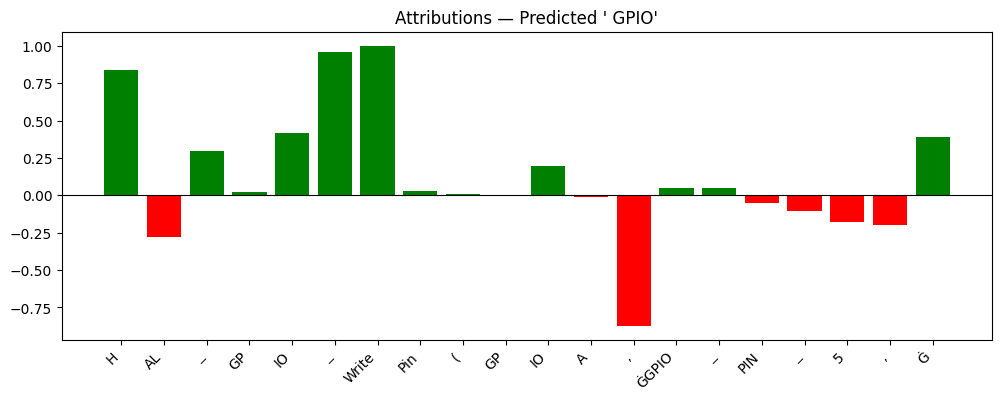

In [ ]:
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from captum.attr import IntegratedGradients

# Use inline plotting
%matplotlib inline

# Load sample symbol table JSON snippet
symbol_data = {
    "symbols": [
        {"name": "CPU_CACHE_Enable", "signature": ""},
        {"name": "CallConstructors", "signature": ""},
        {"name": "Error_Handler", "signature": ""},
        {"name": "Error_handler", "signature": ""},
        {"name": "EthCyclicTaskFunc", "signature": ""},
        {"name": "HAL_DAC_MspDeInit", "signature": ""}
        # ... add more entries as needed
    ]
}
symbol_names = {s["name"] for s in symbol_data["symbols"]}

# Load model and tokenizer (assuming MODEL_DIR is defined)
MODEL_DIR = "best-stm32-pytorch"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_DIR, local_files_only=True)
model = GPT2LMHeadModel.from_pretrained(MODEL_DIR, local_files_only=True).to(device)
model.eval()
model.can_generate = True

def get_token_attributions(prompt, target_token=None):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    attn_mask0 = inputs["attention_mask"]
    input_ids = inputs["input_ids"]

    if target_token is None:
        with torch.no_grad():
            logits = model(**inputs).logits[0, -1, :]
            tid = torch.argmax(logits).item()
            predicted = tokenizer.decode([tid])
    else:
        tids = tokenizer.encode(target_token, add_special_tokens=False)
        tid = tids[0]
        predicted = target_token

    embeds = model.get_input_embeddings()(input_ids)
    def pred_fn(embeds_batch):
        bs = embeds_batch.shape[0]
        mask = attn_mask0.repeat(bs, 1)
        out = model(inputs_embeds=embeds_batch, attention_mask=mask)
        return out.logits[:, -1, tid]

    ig = IntegratedGradients(pred_fn)
    attributions, _ = ig.attribute(
        embeds, baselines=torch.zeros_like(embeds), return_convergence_delta=True
    )
    scores = attributions.sum(dim=-1).detach().cpu().numpy()[0]
    tokens = [tokenizer.convert_ids_to_tokens(i.item()) for i in input_ids[0]]
    return tokens, scores, predicted

def visualize(tokens, scores, predicted):
    norm = scores / (np.abs(scores).max() or 1.0)
    fig, ax = plt.subplots(figsize=(12, 4))
    bars = ax.bar(range(len(tokens)), norm, color=['green' if v>0 else 'red' for v in norm])
    for idx, tok in enumerate(tokens):
        if tok in symbol_names:
            bars[idx].set_edgecolor('blue')
            bars[idx].set_linewidth(2)
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(f"Attributions — Predicted '{predicted}'")
    plt.show()

# Example prompt
prompt = "HAL_GPIO_WritePin(GPIOA, GPIO_PIN_5, "
tokens, scores, pred = get_token_attributions(prompt)
visualize(tokens, scores, pred)

In [ ]:
import torch
import json
import numpy as np
from scipy.special import softmax     # ← use scipy.special
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from captum.attr import IntegratedGradients

#─── Setup (as before) ──────────────────────────────────────────────────────────
MODEL_DIR = "best-stm32-pytorch"
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_DIR, local_files_only=True)
model     = GPT2LMHeadModel.from_pretrained(MODEL_DIR, local_files_only=True).to(device)
model.eval()
model.can_generate = True

try:
    with open("symbol_table.json") as f:
        symbol_names = {s["name"] for s in json.load(f).get("symbols", [])}
except FileNotFoundError:
    symbol_names = set()

#─── Core Attribution + Delta ─────────────────────────────────────────────────
def get_token_attributions(prompt, target_token=None):
    inputs     = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids  = inputs["input_ids"]
    attn_mask0 = inputs["attention_mask"]

    if target_token is None:
        with torch.no_grad():
            logits = model(**inputs).logits[0, -1, :]
            tid    = torch.argmax(logits).item()
            predicted = tokenizer.decode([tid])
    else:
        tid = tokenizer.encode(target_token, add_special_tokens=False)[0]
        predicted = target_token

    embeds = model.get_input_embeddings()(input_ids)

    def pred_fn(embeds_batch):
        bs = embeds_batch.shape[0]
        mask = attn_mask0.repeat(bs, 1)
        out  = model(inputs_embeds=embeds_batch, attention_mask=mask)
        return out.logits[:, -1, tid]

    ig = IntegratedGradients(pred_fn)
    attributions, delta = ig.attribute(
        embeds,
        baselines=torch.zeros_like(embeds),
        return_convergence_delta=True
    )
    scores = attributions.sum(dim=-1).detach().cpu().numpy()[0]
    tokens = [tokenizer.convert_ids_to_tokens(i.item()) for i in input_ids[0]]

    # get full distribution and apply correct softmax
    with torch.no_grad():
        full_logits = model(**inputs).logits[0, -1, :].cpu().numpy()
    probs = softmax(full_logits)  # ← corrected here

    return tokens, scores, predicted, float(delta), probs

#─── Metrics Computation ───────────────────────────────────────────────────────
def compute_metrics(scores, delta, probs):
    metrics = {}
    abs_scores = np.abs(scores)

    metrics['IG delta']         = delta
    metrics['Avg |attr|']       = abs_scores.mean()
    metrics['Max |attr|']       = abs_scores.max()
    pos = (scores > 0).sum()
    neg = (scores < 0).sum()
    metrics['# positive']       = pos
    metrics['# negative']       = neg
    metrics['Pos/Neg ratio']    = pos/(neg or 1)

    entropy = -np.sum(probs * np.log(probs + 1e-12))
    metrics['Entropy']          = entropy
    metrics['Perplexity']       = float(np.exp(entropy))

    n = len(probs)
    sorted_p = np.sort(probs)
    gini = (2 * np.sum((np.arange(1, n+1) * sorted_p)) / (n * sorted_p.sum())) - ((n+1)/n)
    metrics['Gini']             = gini

    metrics['Top1 prob']        = float(probs.max())
    metrics['Evenness']         = entropy/np.log(len(probs))

    return metrics

#─── Visualization ────────────────────────────────────────────────────────────
def visualize_attributions(tokens, scores, pred_tok):
    norm = scores / (np.abs(scores).max() or 1.0)
    colors = ['green' if v>0 else 'red' for v in norm]
    fig, ax = plt.subplots(figsize=(12, 5))
    bars = ax.bar(range(len(tokens)), norm, color=colors)
    for idx, tok in enumerate(tokens):
        if tok in symbol_names:
            bars[idx].set_edgecolor('blue')
            bars[idx].set_linewidth(2)
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_ylabel("Attribution (norm.)")
    ax.set_title(f"IG Attributions — Predicted '{pred_tok}'")
    fig.tight_layout()
    return fig

#─── Full Analysis with Metrics ────────────────────────────────────────────────
def analyze_with_metrics(prompt):
    print(f"\n===== FULL METRICS ANALYSIS =====\nPrompt: {prompt!r}\n")
    tokens, scores, pred_tok, delta, probs = get_token_attributions(prompt)

    # Top-5 predictions
    top5 = np.argsort(-probs)[:5]
    print("Top 5 next-token predictions:")
    for idx in top5:
        print(f"  {tokenizer.decode([idx])!r}: {probs[idx]:.4f}")

    # Attribution
    print("\nAttribution scores:")
    for t, s in zip(tokens, scores):
        mark = " *" if t in symbol_names else ""
        print(f"  {t:>10} → {s:+.4f}{mark}")

    # Metrics
    metrics = compute_metrics(scores, delta, probs)
    print("\nComputed Metrics:")
    for name, val in metrics.items():
        print(f"  {name:>15}: {val:.4f}")

    # Visualization
    fig = visualize_attributions(tokens, scores, pred_tok)
    fig.savefig("metric_attributions.png")
    plt.close(fig)
    print("\nSaved chart as 'metric_attributions.png'")

#─── Run it ───────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    sample = "HAL_GPIO_WritePin(GPIOA, GPIO_PIN_5, "
    analyze_with_metrics(sample)



===== FULL METRICS ANALYSIS =====
Prompt: 'HAL_GPIO_WritePin(GPIOA, GPIO_PIN_5, '

Top 5 next-token predictions:
  ' GPIO': 0.9672
  ' ': 0.0083
  ' gp': 0.0049
  ' D': 0.0012
  'GP': 0.0010

Attribution scores:
           H → +17.1954
          AL → -5.6817
           _ → +6.0965
          GP → +0.4574
          IO → +8.4940
           _ → +19.6387
       Write → +20.5038
         Pin → +0.6144
           ( → +0.2169
          GP → +0.0678
          IO → +4.0103
           A → -0.1985
           , → -17.8875
       ĠGPIO → +0.9799
           _ → +1.0244
         PIN → -1.1230
           _ → -2.1006
           5 → -3.6416
           , → -4.1115
           Ġ → +8.0054

Computed Metrics:
         IG delta: -0.4005
       Avg |attr|: 6.1025
       Max |attr|: 20.5038
       # positive: 13.0000
       # negative: 7.0000
    Pos/Neg ratio: 1.8571
          Entropy: 0.2714
       Perplexity: 1.3118
             Gini: 0.9999
        Top1 prob: 0.9672
         Evenness: 0.0251

Saved chart as

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ─── New Metrics ───────────────────────────────────────────────────────────────
def top_k_mass(attributions, k=3):
    """Fraction of total |attribution| contained in the top-k tokens."""
    abs_attr = np.abs(attributions)
    topk     = np.sort(abs_attr)[-k:]
    return topk.sum() / abs_attr.sum()

def attribution_entropy(attributions):
    """Shannon entropy over normalized absolute‐attribution distribution."""
    abs_attr = np.abs(attributions)
    probs    = abs_attr / abs_attr.sum()
    return -np.sum(probs * np.log(probs + 1e-12))

# ─── Plotting Helpers ─────────────────────────────────────────────────────────
def plot_topk_mass(attributions, ks=(1,3,5), ax=None):
    """Bar chart: top-k mass for each k in ks."""
    masses = [top_k_mass(attributions, k) for k in ks]
    ax = ax or plt.gca()
    ax.bar([str(k) for k in ks], masses)
    ax.set_title("Top-k Attribution Mass")
    ax.set_ylabel("Mass fraction")
    return ax

def plot_attr_entropy(attributions, ax=None):
    """Single-bar chart: overall attribution entropy."""
    H = attribution_entropy(attributions)
    ax = ax or plt.gca()
    ax.bar(["Entropy"], [H])
    ax.set_title("Attribution Entropy")
    return ax

# ─── In your analyze_with_metrics (after computing `scores`) ────────────────
def analyze_with_new_metrics(prompt):
    tokens, scores, pred_tok, delta, probs = get_token_attributions(prompt)

    # existing prints...
    # now compute our two new metrics
    H    = attribution_entropy(scores)
    m3   = top_k_mass(scores, k=3)

    print(f"\nAttribution entropy: {H:.4f}")
    print(f"Top-3 attribution mass: {m3:.4f}")

    # create a small figure with 3 panels:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    # 1) IG bar chart
    visualize_attributions(tokens, scores, pred_tok, title="IG Attributions", ax=axes[0])
    # 2) top-k mass
    plot_topk_mass(scores, ks=(1,3,5), ax=axes[1])
    # 3) entropy
    plot_attr_entropy(scores, ax=axes[2])
    fig.tight_layout()
    fig.savefig("full_metric_plot.png")
    plt.close(fig)
    print("Saved combined plot to 'full_metric_plot.png'")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ─── New Metrics ───────────────────────────────────────────────────────────────
def top_k_mass(attributions, k=3):
    """Fraction of total |attribution| in the top-k tokens."""
    abs_attr = np.abs(attributions)
    topk     = np.sort(abs_attr)[-k:]
    return topk.sum() / abs_attr.sum()

def attribution_entropy(attributions):
    """Shannon entropy over the normalized |attribution| distribution."""
    abs_attr = np.abs(attributions)
    p        = abs_attr / abs_attr.sum()
    return -np.sum(p * np.log(p + 1e-12))

# ─── Plotting Helpers ─────────────────────────────────────────────────────────
def plot_topk_mass(attributions, ks=(1,3,5), ax=None):
    masses = [top_k_mass(attributions, k) for k in ks]
    ax = ax or plt.gca()
    ax.bar([f"Top {k}" for k in ks], masses)
    ax.set_ylabel("Mass fraction")
    ax.set_title("Top-k Attribution Mass")
    return ax

def plot_attr_entropy(attributions, ax=None):
    H = attribution_entropy(attributions)
    ax = ax or plt.gca()
    ax.bar(["Entropy"], [H])
    ax.set_title("Attribution Entropy")
    return ax

# ─── Combined Inline Display ─────────────────────────────────────────────────
def analyze_and_show(prompt):
    # get tokens, IG scores, and predicted token (reuse your existing function)
    tokens, scores, pred_tok, delta, probs = get_token_attributions(prompt)

    # print minimal metrics
    print(f"Predicted token: '{pred_tok}'")
    print(f"  • Attribution Entropy: {attribution_entropy(scores):.4f}")
    print(f"  • Top-3 Attribution Mass: {top_k_mass(scores, 3):.4f}\n")

    # plot inline
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    # IG bar chart (modify your visualize to take an ax)
    visualize_attributions(tokens, scores, pred_tok, title="IG Attributions", ax=axes[0])
    plot_topk_mass(scores, ks=(1,3,5), ax=axes[1])
    plot_attr_entropy(scores, ax=axes[2])
    fig.tight_layout()
    plt.show()


Prompt          : 'HAL_GPIO_WritePin(GPIOA, GPIO_PIN_5, '
Predicted token : ' GPIO'
IG convergence  : -0.4005
Entropy         : 2.4044
Top-3 mass      : 0.4755



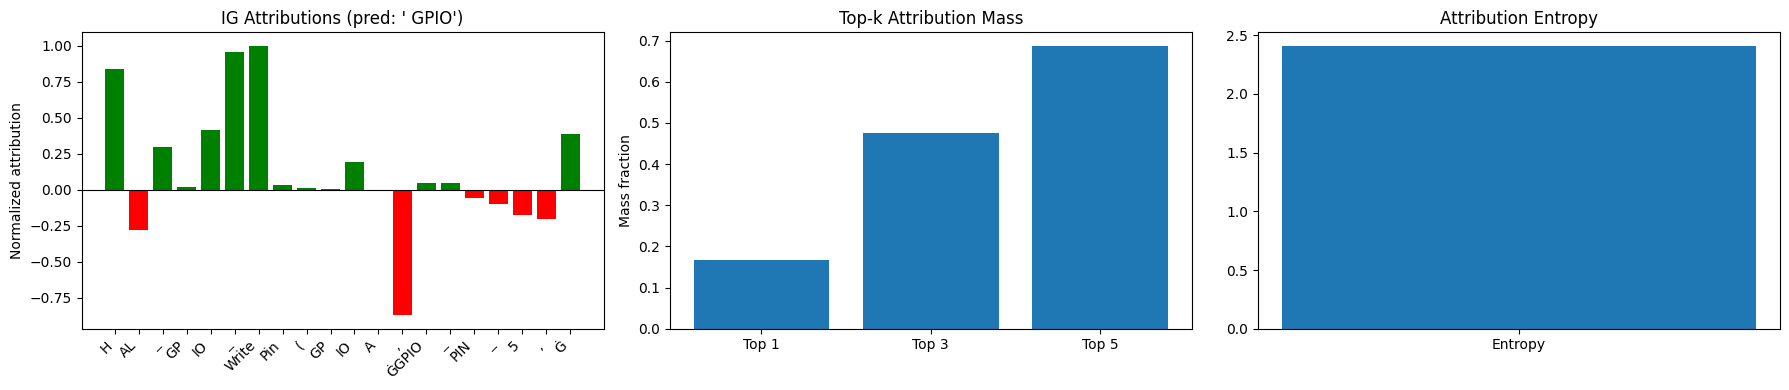

In [ ]:
# Install dependencies if needed:
# !pip install transformers torch captum matplotlib

import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from captum.attr import IntegratedGradients

# ─── Setup ─────────────────────────────────────────────────────────────────────
MODEL_DIR = "best-stm32-pytorch"
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_DIR, local_files_only=True)
model     = GPT2LMHeadModel.from_pretrained(MODEL_DIR,   local_files_only=True).to(device)
model.eval()
# Monkey‐patch generate on some GPT2 versions
model.can_generate = True

# Load symbol table if present
try:
    with open("symbol_table.json", "r") as f:
        symbol_names = {s["name"] for s in json.load(f).get("symbols", [])}
except FileNotFoundError:
    symbol_names = set()


# ─── Core Attribution Function ────────────────────────────────────────────────
def get_token_attributions(prompt, target_token=None):
    """
    Returns:
      tokens: list of token strings
      scores: numpy array of IG attribution per token
      predicted_token: the token being explained
      delta: IG convergence delta
      probs: full softmax distribution for next‐token
    """
    inputs     = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids  = inputs["input_ids"]            # [1, seq_len]
    attn_mask0 = inputs["attention_mask"]       # [1, seq_len]

    # Choose target token ID
    if target_token is None:
        with torch.no_grad():
            logits = model(**inputs).logits[0, -1, :]
            tid    = torch.argmax(logits).item()
            predicted_token = tokenizer.decode([tid])
    else:
        tids = tokenizer.encode(target_token, add_special_tokens=False)
        if not tids:
            raise ValueError(f"Cannot encode target token {target_token!r}")
        tid = tids[0]
        predicted_token = target_token

    # Get embeddings
    embeds = model.get_input_embeddings()(input_ids)  # [1, seq_len, emb_dim]

    # Prediction function for IG, repeating attention_mask
    def pred_fn(embeds_batch):
        batch_size = embeds_batch.shape[0]
        mask = attn_mask0.repeat(batch_size, 1)         # [batch_size, seq_len]
        out  = model(inputs_embeds=embeds_batch, attention_mask=mask)
        return out.logits[:, -1, tid]

    # Compute IG attributions
    ig = IntegratedGradients(pred_fn)
    attributions, delta = ig.attribute(
        embeds,
        baselines=torch.zeros_like(embeds),
        return_convergence_delta=True
    )
    scores = attributions.sum(dim=-1).detach().cpu().numpy()[0]  # [seq_len]

    # Full next-token distribution
    with torch.no_grad():
        full_logits = model(**inputs).logits[0, -1, :].cpu().numpy()
    from scipy.special import softmax
    probs = softmax(full_logits)

    # Decode tokens
    tokens = [tokenizer.convert_ids_to_tokens(i.item()) for i in input_ids[0]]
    return tokens, scores, predicted_token, float(delta), probs


# ─── Visualization (IG bar chart) ─────────────────────────────────────────────
def visualize_attributions(tokens, scores, pred_tok, ax):
    """
    Draws the IG bar chart on the given Axes.
    Highlights known symbols with a blue border.
    """
    norm = scores / (np.abs(scores).max() or 1.0)
    colors = ['green' if v>=0 else 'red' for v in norm]
    bars = ax.bar(range(len(tokens)), norm, color=colors)
    for idx, tok in enumerate(tokens):
        if tok in symbol_names:
            bars[idx].set_edgecolor('blue')
            bars[idx].set_linewidth(2.0)
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(f"IG Attributions (pred: '{pred_tok}')")
    ax.set_ylabel("Normalized attribution")


# ─── New Metrics ──────────────────────────────────────────────────────────────
def top_k_mass(attributions, k=3):
    """Fraction of total |attribution| in the top-k tokens."""
    abs_attr = np.abs(attributions)
    topk     = np.sort(abs_attr)[-k:]
    return topk.sum() / abs_attr.sum()

def attribution_entropy(attributions):
    """Shannon entropy over normalized |attribution| distribution."""
    abs_attr = np.abs(attributions)
    p = abs_attr / abs_attr.sum()
    return -np.sum(p * np.log(p + 1e-12))


# ─── Plotting Helpers for Metrics ────────────────────────────────────────────
def plot_topk_mass(attributions, ks=(1,3,5), ax=None):
    masses = [top_k_mass(attributions, k) for k in ks]
    ax = ax or plt.gca()
    ax.bar([f"Top {k}" for k in ks], masses)
    ax.set_title("Top-k Attribution Mass")
    ax.set_ylabel("Mass fraction")
    return ax

def plot_attr_entropy(attributions, ax=None):
    H = attribution_entropy(attributions)
    ax = ax or plt.gca()
    ax.bar(["Entropy"], [H])
    ax.set_title("Attribution Entropy")
    return ax


# ─── Combined Inline Display ─────────────────────────────────────────────────
def analyze_and_show(prompt):
    tokens, scores, pred_tok, delta, probs = get_token_attributions(prompt)

    # Print minimal metrics
    print(f"Prompt          : {prompt!r}")
    print(f"Predicted token : '{pred_tok}'")
    print(f"IG convergence  : {delta:.4f}")
    print(f"Entropy         : {attribution_entropy(scores):.4f}")
    print(f"Top-3 mass      : {top_k_mass(scores, 3):.4f}\n")

    # Inline plots side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    visualize_attributions(tokens, scores, pred_tok, ax=axes[0])
    plot_topk_mass(scores, ks=(1,3,5), ax=axes[1])
    plot_attr_entropy(scores, ax=axes[2])
    fig.tight_layout()
    plt.show()


# ─── Example Usage ────────────────────────────────────────────────────────────
if __name__ == "__main__":
    sample = "HAL_GPIO_WritePin(GPIOA, GPIO_PIN_5, "
    analyze_and_show(sample)


In [ ]:
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from captum.attr import IntegratedGradients
from scipy.special import softmax

# ─── Setup ─────────────────────────────────────────────────────────────────────
MODEL_DIR = "best-stm32-pytorch"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_DIR, local_files_only=True)
model = GPT2LMHeadModel.from_pretrained(MODEL_DIR, local_files_only=True).to(device)
model.eval()
model.can_generate = True

try:
    with open("symbol_table.json", "r") as f:
        symbol_names = {s["name"] for s in json.load(f).get("symbols", [])}
except FileNotFoundError:
    symbol_names = set()


def get_token_attributions(prompt, target_token=None):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]
    attn_mask0 = inputs["attention_mask"]

    if target_token is None:
        with torch.no_grad():
            logits = model(**inputs).logits[0, -1, :]
            tid = torch.argmax(logits).item()
            predicted_token = tokenizer.decode([tid])
    else:
        tids = tokenizer.encode(target_token, add_special_tokens=False)
        if not tids:
            raise ValueError(f"Cannot encode target token {target_token!r}")
        tid = tids[0]
        predicted_token = target_token

    embeds = model.get_input_embeddings()(input_ids)

    def pred_fn(embeds_batch):
        batch_size = embeds_batch.shape[0]
        mask = attn_mask0.repeat(batch_size, 1)
        out = model(inputs_embeds=embeds_batch, attention_mask=mask)
        return out.logits[:, -1, tid]

    ig = IntegratedGradients(pred_fn)
    attributions, delta = ig.attribute(
        embeds, baselines=torch.zeros_like(embeds), return_convergence_delta=True
    )
    scores = attributions.sum(dim=-1).detach().cpu().numpy()[0]

    with torch.no_grad():
        full_logits = model(**inputs).logits[0, -1, :].cpu().numpy()
    probs = softmax(full_logits)

    tokens = [tokenizer.convert_ids_to_tokens(i.item()) for i in input_ids[0]]
    return tokens, scores, predicted_token, float(delta), probs


def top_k_mass(attributions, k=3):
    abs_attr = np.abs(attributions)
    topk = np.sort(abs_attr)[-k:]
    return topk.sum() / abs_attr.sum()


def attribution_entropy(attributions):
    abs_attr = np.abs(attributions)
    p = abs_attr / abs_attr.sum()
    return -np.sum(p * np.log(p + 1e-12))


def run_multiple(prompts):
    igs, ents, top3s = [], [], []
    for prompt in prompts:
        _, scores, pred_tok, delta, probs = get_token_attributions(prompt)
        igs.append(delta)
        ents.append(attribution_entropy(scores))
        top3s.append(top_k_mass(scores, 3))
    return {
        "IG convergence": np.mean(igs),
        "Entropy": np.mean(ents),
        "Top-3 mass": np.mean(top3s)
    }


sample_prompts = [
    "HAL_GPIO_WritePin(GPIOA, GPIO_PIN_5, ",
    "MX_USART2_UART_Init(); // initialize UART",
    "HAL_ADC_Start(&hadc1); // start ADC",
    "SystemClock_Config(); // configure clocks",
    "HAL_TIM_Base_Start_IT(&htim2); // start timer"
]

results = run_multiple(sample_prompts)
results


{'IG convergence': 0.09463663101196289,
 'Entropy': 2.327677,
 'Top-3 mass': 0.50005066}

In [ ]:
!pip install captum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [ ]:
!unzip -o best-stm32-pytorch.zip -d best-stm32-pytorch


Archive:  best-stm32-pytorch.zip
   creating: best-stm32-pytorch/best-stm32-pytorch/
  inflating: best-stm32-pytorch/best-stm32-pytorch/model.safetensors  
  inflating: best-stm32-pytorch/best-stm32-pytorch/tokenizer_config.json  
  inflating: best-stm32-pytorch/best-stm32-pytorch/special_tokens_map.json  
  inflating: best-stm32-pytorch/best-stm32-pytorch/merges.txt  
  inflating: best-stm32-pytorch/best-stm32-pytorch/vocab.json  
  inflating: best-stm32-pytorch/best-stm32-pytorch/config.json  
  inflating: best-stm32-pytorch/best-stm32-pytorch/generation_config.json  
  inflating: best-stm32-pytorch/best-stm32-pytorch/tokenizer.json  


Archive:  best-stm32-pytorch.zip
   creating: ./best-stm32-pytorch/
  inflating: ./best-stm32-pytorch/model.safetensors  
  inflating: ./best-stm32-pytorch/tokenizer_config.json  
  inflating: ./best-stm32-pytorch/special_tokens_map.json  
  inflating: ./best-stm32-pytorch/merges.txt  
  inflating: ./best-stm32-pytorch/vocab.json  
  inflating: ./best-stm32-pytorch/config.json  
  inflating: ./best-stm32-pytorch/generation_config.json  
  inflating: ./best-stm32-pytorch/tokenizer.json  
Prompt          : 'HAL_GPIO_WritePin(GPIOA, GPIO_PIN_5, '
Predicted token : ' GPIO'
IG convergence  : -0.4008
Entropy         : 2.4044
Top-3 mass      : 0.4755



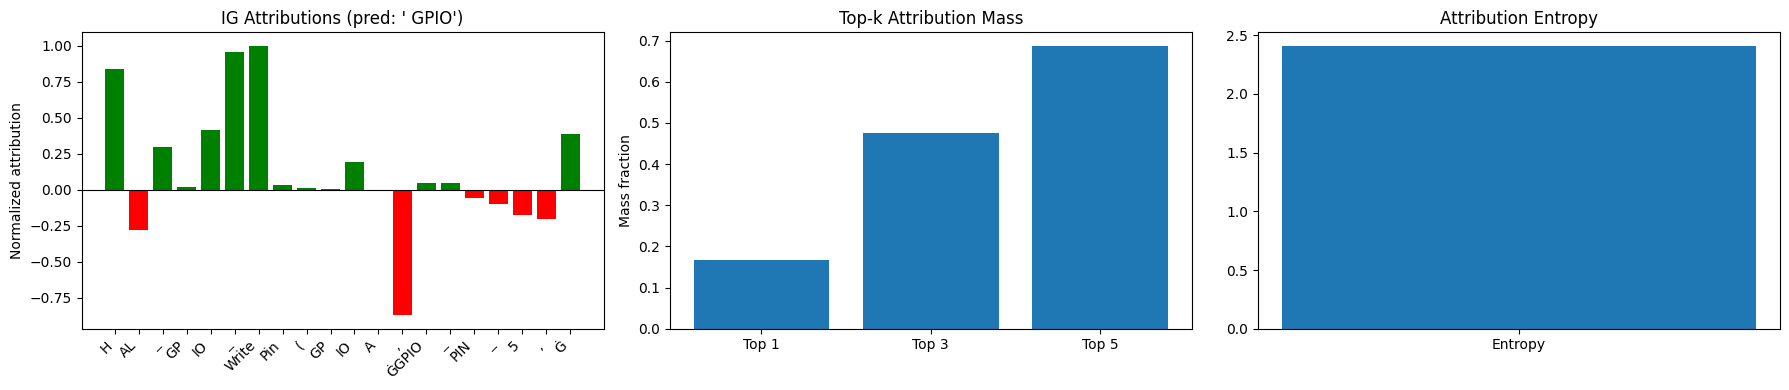

In [ ]:
import os
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from captum.attr import IntegratedGradients
from scipy.special import softmax

# ─── Unzipping Model Correctly ─────────────────────────────────────────────────
# Ensure no double folders when unzipping
!rm -rf best-stm32-pytorch  # Remove any existing folder
!unzip best-stm32-pytorch.zip -d .  # Unzip correctly into the current directory

# ─── Setup ─────────────────────────────────────────────────────────────────────
MODEL_DIR = "best-stm32-pytorch"  # Correct folder after unzipping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_DIR, local_files_only=True)
model = GPT2LMHeadModel.from_pretrained(MODEL_DIR, local_files_only=True).to(device)
model.eval()

# ─── Load symbol table if present ─────────────────────────────────────────────
try:
    with open("symbol_table.json", "r") as f:
        symbol_names = {s["name"] for s in json.load(f).get("symbols", [])}
except FileNotFoundError:
    symbol_names = set()

# ─── Core Attribution Function ────────────────────────────────────────────────
def get_token_attributions(prompt, target_token=None):
    """
    Returns:
      tokens: list of token strings
      scores: numpy array of IG attribution per token
      predicted_token: the token being explained
      delta: IG convergence delta
      probs: full softmax distribution for next‐token
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]  # [1, seq_len]
    attn_mask0 = inputs["attention_mask"]  # [1, seq_len]

    # Choose target token ID
    if target_token is None:
        with torch.no_grad():
            logits = model(**inputs).logits[0, -1, :]
            tid = torch.argmax(logits).item()
            predicted_token = tokenizer.decode([tid])
    else:
        tids = tokenizer.encode(target_token, add_special_tokens=False)
        if not tids:
            raise ValueError(f"Cannot encode target token {target_token!r}")
        tid = tids[0]
        predicted_token = target_token

    # Get embeddings
    embeds = model.get_input_embeddings()(input_ids)  # [1, seq_len, emb_dim]

    # Prediction function for IG, repeating attention_mask
    def pred_fn(embeds_batch):
        batch_size = embeds_batch.shape[0]
        mask = attn_mask0.repeat(batch_size, 1)  # [batch_size, seq_len]
        out = model(inputs_embeds=embeds_batch, attention_mask=mask)
        return out.logits[:, -1, tid]

    # Compute IG attributions
    ig = IntegratedGradients(pred_fn)
    attributions, delta = ig.attribute(
        embeds,
        baselines=torch.zeros_like(embeds),
        return_convergence_delta=True
    )
    scores = attributions.sum(dim=-1).detach().cpu().numpy()[0]  # [seq_len]

    # Full next-token distribution
    with torch.no_grad():
        full_logits = model(**inputs).logits[0, -1, :].cpu().numpy()
    probs = softmax(full_logits)

    # Decode tokens
    tokens = [tokenizer.convert_ids_to_tokens(i.item()) for i in input_ids[0]]
    return tokens, scores, predicted_token, float(delta), probs

# ─── Visualization (IG bar chart) ─────────────────────────────────────────────
def visualize_attributions(tokens, scores, pred_tok, ax):
    """
    Draws the IG bar chart on the given Axes.
    Highlights known symbols with a blue border.
    """
    norm = scores / (np.abs(scores).max() or 1.0)
    colors = ['green' if v >= 0 else 'red' for v in norm]
    bars = ax.bar(range(len(tokens)), norm, color=colors)
    for idx, tok in enumerate(tokens):
        if tok in symbol_names:
            bars[idx].set_edgecolor('blue')
            bars[idx].set_linewidth(2.0)
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(f"IG Attributions (pred: '{pred_tok}')")
    ax.set_ylabel("Normalized attribution")

# ─── New Metrics ──────────────────────────────────────────────────────────────
def top_k_mass(attributions, k=3):
    """Fraction of total |attribution| in the top-k tokens."""
    abs_attr = np.abs(attributions)
    topk = np.sort(abs_attr)[-k:]
    return topk.sum() / abs_attr.sum()

def attribution_entropy(attributions):
    """Shannon entropy over normalized |attribution| distribution."""
    abs_attr = np.abs(attributions)
    p = abs_attr / abs_attr.sum()
    return -np.sum(p * np.log(p + 1e-12))

# ─── Plotting Helpers for Metrics ────────────────────────────────────────────
def plot_topk_mass(attributions, ks=(1, 3, 5), ax=None):
    masses = [top_k_mass(attributions, k) for k in ks]
    ax = ax or plt.gca()
    ax.bar([f"Top {k}" for k in ks], masses)
    ax.set_title("Top-k Attribution Mass")
    ax.set_ylabel("Mass fraction")
    return ax

def plot_attr_entropy(attributions, ax=None):
    H = attribution_entropy(attributions)
    ax = ax or plt.gca()
    ax.bar(["Entropy"], [H])
    ax.set_title("Attribution Entropy")
    return ax

# ─── Combined Inline Display ─────────────────────────────────────────────────
def analyze_and_show(prompt):
    tokens, scores, pred_tok, delta, probs = get_token_attributions(prompt)

    # Print minimal metrics
    print(f"Prompt          : {prompt!r}")
    print(f"Predicted token : '{pred_tok}'")
    print(f"IG convergence  : {delta:.4f}")
    print(f"Entropy         : {attribution_entropy(scores):.4f}")
    print(f"Top-3 mass      : {top_k_mass(scores, 3):.4f}\n")

    # Inline plots side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    visualize_attributions(tokens, scores, pred_tok, ax=axes[0])
    plot_topk_mass(scores, ks=(1, 3, 5), ax=axes[1])
    plot_attr_entropy(scores, ax=axes[2])
    fig.tight_layout()
    plt.show()

# ─── Example Usage ────────────────────────────────────────────────────────────
if __name__ == "__main__":
    sample = "HAL_GPIO_WritePin(GPIOA, GPIO_PIN_5, "
    analyze_and_show(sample)


Average Metrics from 5 Prompts:
Average IG convergence: -0.0590
Average Entropy: 2.5010
Average Top-3 Mass: 0.4446


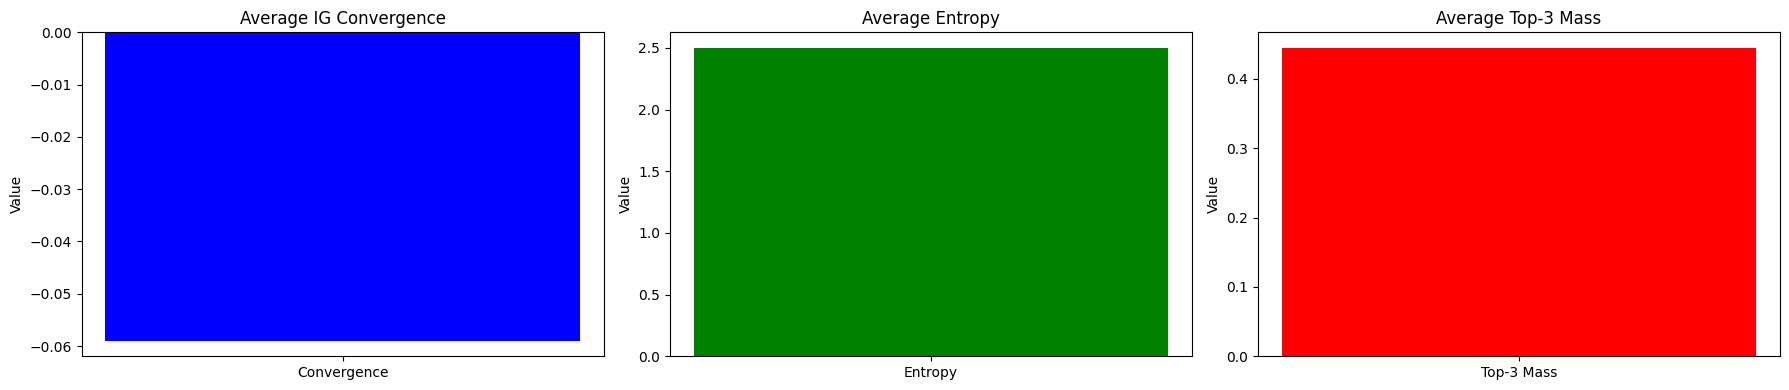

In [ ]:
import os
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from captum.attr import IntegratedGradients
from scipy.special import softmax

# ─── Unzipping Model Correctly ─────────────────────────────────────────────────
# Ensure no double folders when unzipping
# !rm -rf best-stm32-pytorch  # Remove any existing folder
# !unzip best-stm32-pytorch.zip -d .  # Unzip correctly into the current directory

# ─── Setup ─────────────────────────────────────────────────────────────────────
MODEL_DIR = "best-stm32-pytorch"  # Correct folder after unzipping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_DIR, local_files_only=True)
model = GPT2LMHeadModel.from_pretrained(MODEL_DIR, local_files_only=True).to(device)
model.eval()

# ─── Load symbol table if present ─────────────────────────────────────────────
try:
    with open("symbol_table.json", "r") as f:
        symbol_names = {s["name"] for s in json.load(f).get("symbols", [])}
except FileNotFoundError:
    symbol_names = set()

# ─── Core Attribution Function ────────────────────────────────────────────────
def get_token_attributions(prompt, target_token=None):
    """
    Returns:
      tokens: list of token strings
      scores: numpy array of IG attribution per token
      predicted_token: the token being explained
      delta: IG convergence delta
      probs: full softmax distribution for next‐token
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]  # [1, seq_len]
    attn_mask0 = inputs["attention_mask"]  # [1, seq_len]

    # Choose target token ID
    if target_token is None:
        with torch.no_grad():
            logits = model(**inputs).logits[0, -1, :]
            tid = torch.argmax(logits).item()
            predicted_token = tokenizer.decode([tid])
    else:
        tids = tokenizer.encode(target_token, add_special_tokens=False)
        if not tids:
            raise ValueError(f"Cannot encode target token {target_token!r}")
        tid = tids[0]
        predicted_token = target_token

    # Get embeddings
    embeds = model.get_input_embeddings()(input_ids)  # [1, seq_len, emb_dim]

    # Prediction function for IG, repeating attention_mask
    def pred_fn(embeds_batch):
        batch_size = embeds_batch.shape[0]
        mask = attn_mask0.repeat(batch_size, 1)  # [batch_size, seq_len]
        out = model(inputs_embeds=embeds_batch, attention_mask=mask)
        return out.logits[:, -1, tid]

    # Compute IG attributions
    ig = IntegratedGradients(pred_fn)
    attributions, delta = ig.attribute(
        embeds,
        baselines=torch.zeros_like(embeds),
        return_convergence_delta=True
    )
    scores = attributions.sum(dim=-1).detach().cpu().numpy()[0]  # [seq_len]

    # Full next-token distribution
    with torch.no_grad():
        full_logits = model(**inputs).logits[0, -1, :].cpu().numpy()
    probs = softmax(full_logits)

    # Decode tokens
    tokens = [tokenizer.convert_ids_to_tokens(i.item()) for i in input_ids[0]]
    return tokens, scores, predicted_token, float(delta), probs

# ─── Visualization (IG bar chart) ─────────────────────────────────────────────
def visualize_attributions(tokens, scores, pred_tok, ax):
    """
    Draws the IG bar chart on the given Axes.
    Highlights known symbols with a blue border.
    """
    norm = scores / (np.abs(scores).max() or 1.0)
    colors = ['green' if v >= 0 else 'red' for v in norm]
    bars = ax.bar(range(len(tokens)), norm, color=colors)
    for idx, tok in enumerate(tokens):
        if tok in symbol_names:
            bars[idx].set_edgecolor('blue')
            bars[idx].set_linewidth(2.0)
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(f"IG Attributions (pred: '{pred_tok}')")
    ax.set_ylabel("Normalized attribution")

# ─── New Metrics ──────────────────────────────────────────────────────────────
def top_k_mass(attributions, k=3):
    """Fraction of total |attribution| in the top-k tokens."""
    abs_attr = np.abs(attributions)
    topk = np.sort(abs_attr)[-k:]
    return topk.sum() / abs_attr.sum()

def attribution_entropy(attributions):
    """Shannon entropy over normalized |attribution| distribution."""
    abs_attr = np.abs(attributions)
    p = abs_attr / abs_attr.sum()
    return -np.sum(p * np.log(p + 1e-12))

# ─── Plotting Helpers for Metrics ────────────────────────────────────────────
def plot_topk_mass(attributions, ks=(1, 3, 5), ax=None):
    masses = [top_k_mass(attributions, k) for k in ks]
    ax = ax or plt.gca()
    ax.bar([f"Top {k}" for k in ks], masses)
    ax.set_title("Top-k Attribution Mass")
    ax.set_ylabel("Mass fraction")
    return ax

def plot_attr_entropy(attributions, ax=None):
    H = attribution_entropy(attributions)
    ax = ax or plt.gca()
    ax.bar(["Entropy"], [H])
    ax.set_title("Attribution Entropy")
    return ax

# ─── Combined Inline Display ─────────────────────────────────────────────────
def analyze_and_show(prompt):
    tokens, scores, pred_tok, delta, probs = get_token_attributions(prompt)

    # Print minimal metrics
    print(f"Prompt          : {prompt!r}")
    print(f"Predicted token : '{pred_tok}'")
    print(f"IG convergence  : {delta:.4f}")
    print(f"Entropy         : {attribution_entropy(scores):.4f}")
    print(f"Top-3 mass      : {top_k_mass(scores, 3):.4f}\n")

    # Inline plots side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    visualize_attributions(tokens, scores, pred_tok, ax=axes[0])
    plot_topk_mass(scores, ks=(1, 3, 5), ax=axes[1])
    plot_attr_entropy(scores, ax=axes[2])
    fig.tight_layout()
    plt.show()

# ─── Average Metrics from Multiple Prompts ─────────────────────────────────────
def analyze_multiple_prompts(prompts):
    all_convergence = []
    all_entropy = []
    all_top_k_mass = []

    for prompt in prompts:
        tokens, scores, pred_tok, delta, probs = get_token_attributions(prompt)
        all_convergence.append(delta)
        all_entropy.append(attribution_entropy(scores))
        all_top_k_mass.append(top_k_mass(scores, 3))  # Top-3 mass

    # Calculate averages
    avg_convergence = np.mean(all_convergence)
    avg_entropy = np.mean(all_entropy)
    avg_top_k_mass = np.mean(all_top_k_mass)

    print("Average Metrics from 5 Prompts:")
    print(f"Average IG convergence: {avg_convergence:.4f}")
    print(f"Average Entropy: {avg_entropy:.4f}")
    print(f"Average Top-3 Mass: {avg_top_k_mass:.4f}")

    # Inline plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].bar(["Convergence"], [avg_convergence], color='blue')
    axes[0].set_title("Average IG Convergence")
    axes[0].set_ylabel("Value")

    axes[1].bar(["Entropy"], [avg_entropy], color='green')
    axes[1].set_title("Average Entropy")
    axes[1].set_ylabel("Value")

    axes[2].bar(["Top-3 Mass"], [avg_top_k_mass], color='red')
    axes[2].set_title("Average Top-3 Mass")
    axes[2].set_ylabel("Value")

    fig.tight_layout()
    plt.show()


# ─── Example Usage ────────────────────────────────────────────────────────────
if __name__ == "__main__":
    sample_prompts = [
        "HAL_GPIO_WritePin(GPIOA, GPIO_PIN_5, ",
        "HAL_UART_Transmit(&huart1, (uint8_t *)msg, strlen(msg), 1000);",
        "HAL_DAC_Start(&hdac, DAC_CHANNEL_1);",
        "HAL_TIM_Base_Start_IT(&htim3);",
        "HAL_ADC_Start(&hadc1);"
    ]
    analyze_multiple_prompts(sample_prompts)


===== ATTRIBUTION ANALYSIS =====
Prompt 1: 'HAL_GPIO_WritePin(GPIOA, GPIO_PIN_5, '
  Pred: ' GPIO', ΔIG=-0.4194, Ent=2.5230, Top3=0.9804, CosSim=0.5511



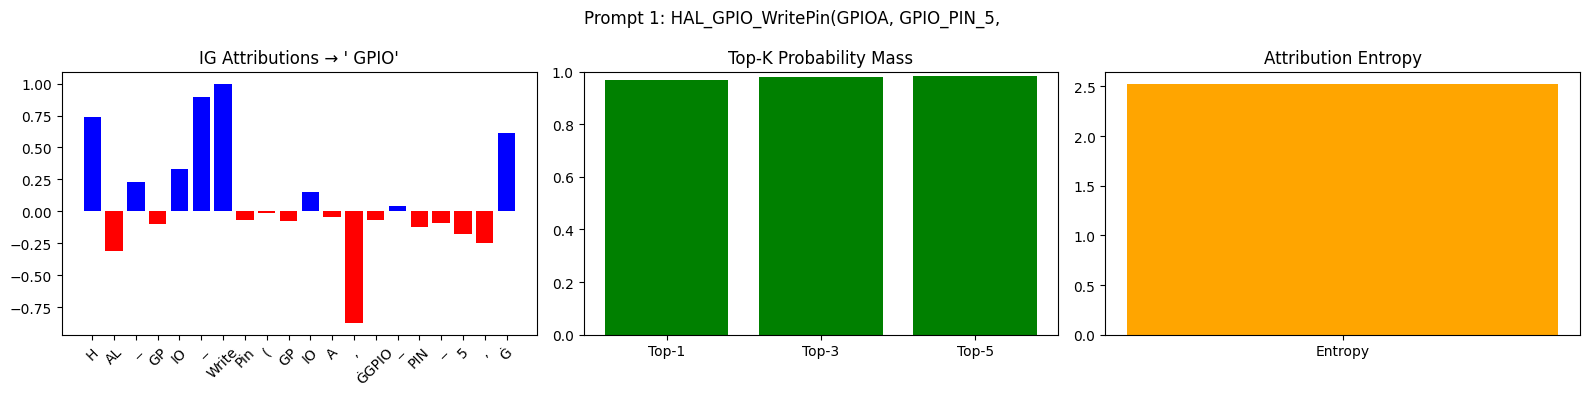

Prompt 2: 'MX_USART2_'
  Pred: 'U', ΔIG=-0.2273, Ent=1.4874, Top3=0.9999, CosSim=0.4928



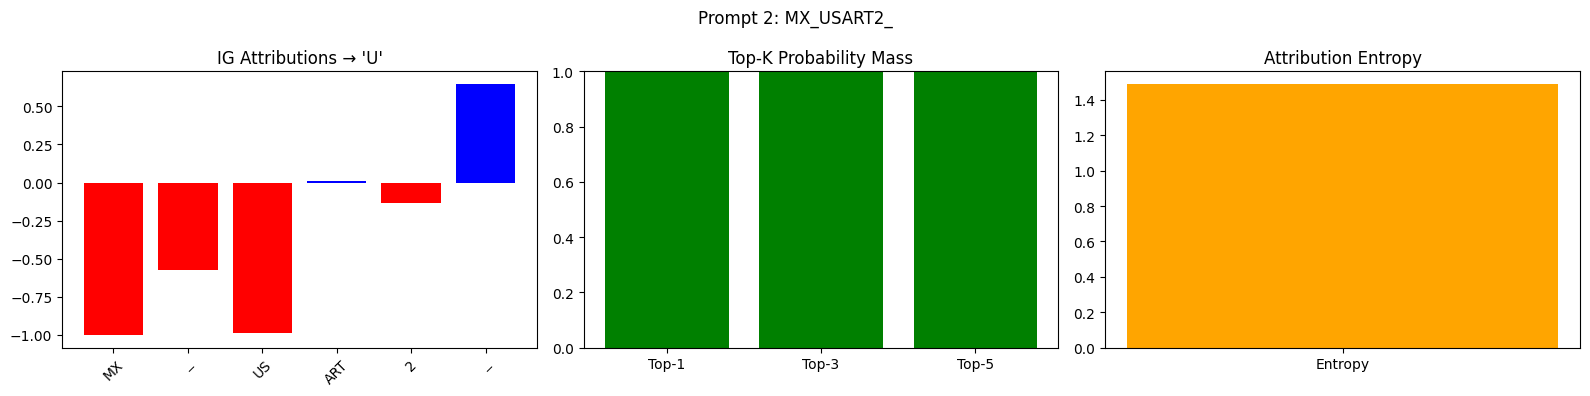

Prompt 3: 'if (HAL_ADC_PollForConversion(&hadc1, '
  Pred: ' ', ΔIG=1.6297, Ent=2.5383, Top3=0.3962, CosSim=0.4479



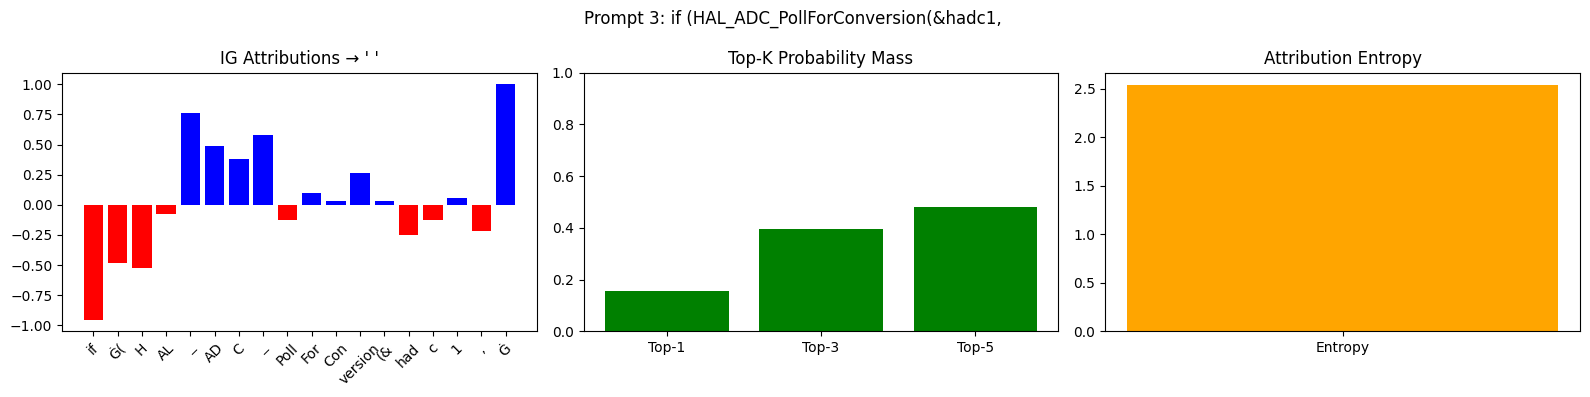

Prompt 4: 'uint32_t adc_val = HAL_ADC_'
  Pred: 'Get', ΔIG=0.3769, Ent=2.2200, Top3=0.9489, CosSim=0.4305



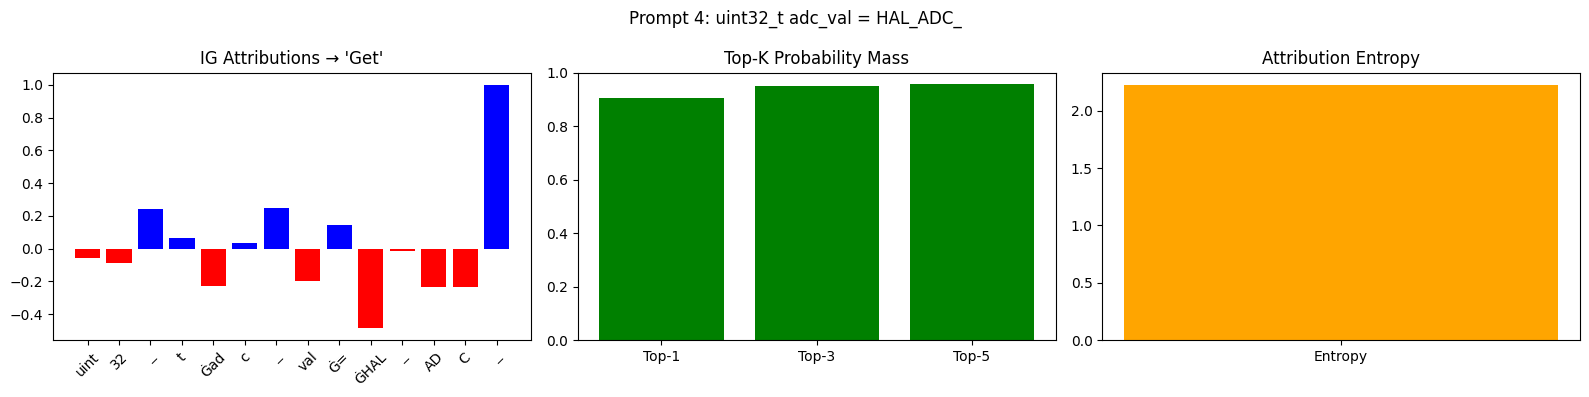

Prompt 5: 'HAL_ADC_'
  Pred: 'Start', ΔIG=0.0225, Ent=1.6305, Top3=0.7887, CosSim=0.4323



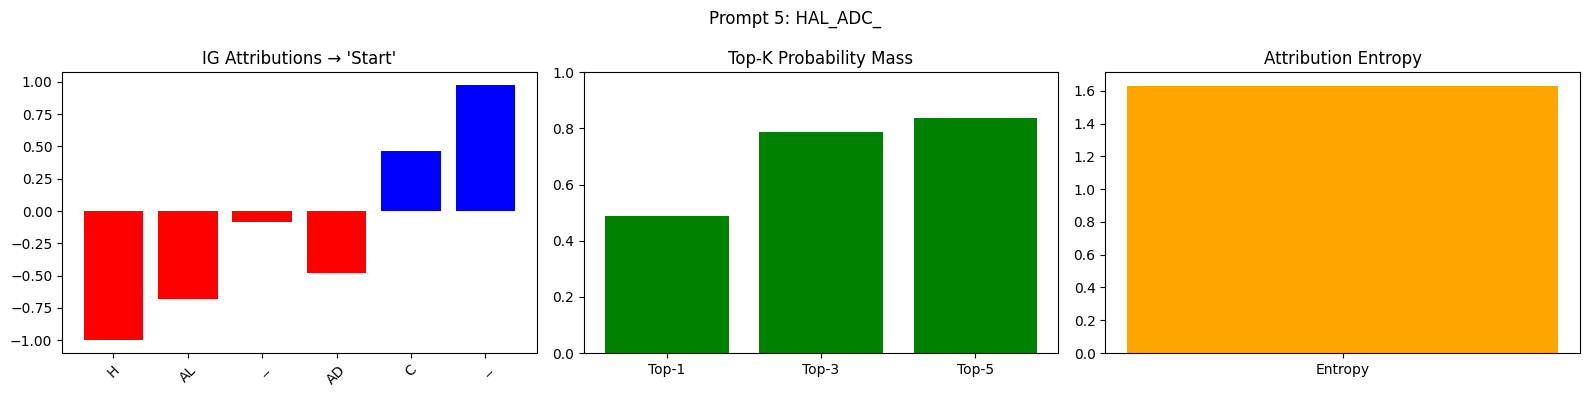

Prompt 6: 'GPIO_InitTypeDef GPIO_InitStruct = {'
  Pred: '0', ΔIG=0.0514, Ent=1.9734, Top3=0.9998, CosSim=0.4640



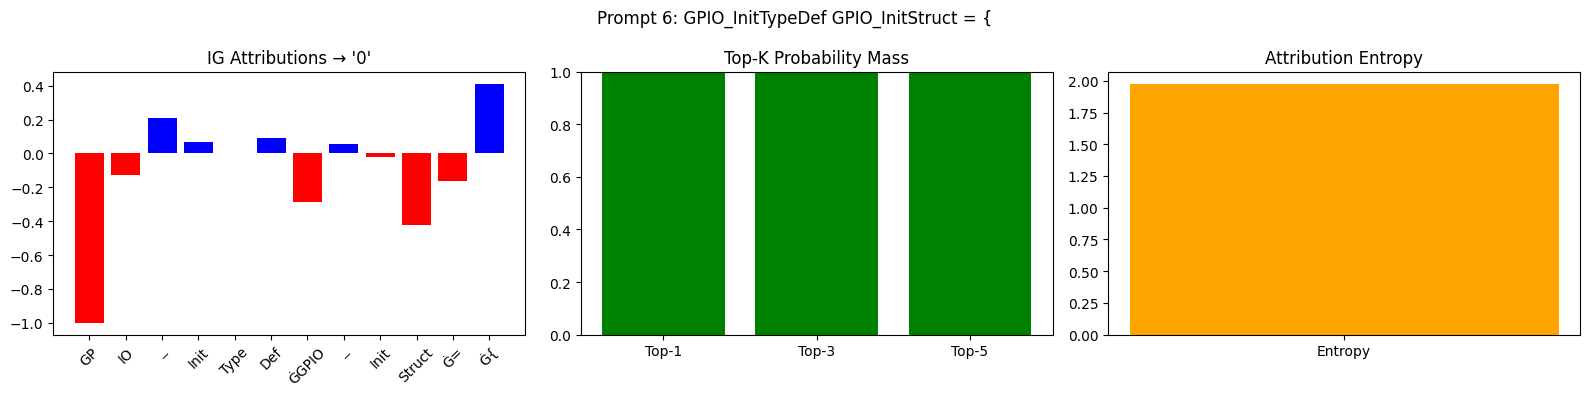

Prompt 7: 'if(status != HAL_OK) {'
  Pred: '<|endoftext|>', ΔIG=0.0103, Ent=1.8280, Top3=0.9937, CosSim=0.3917



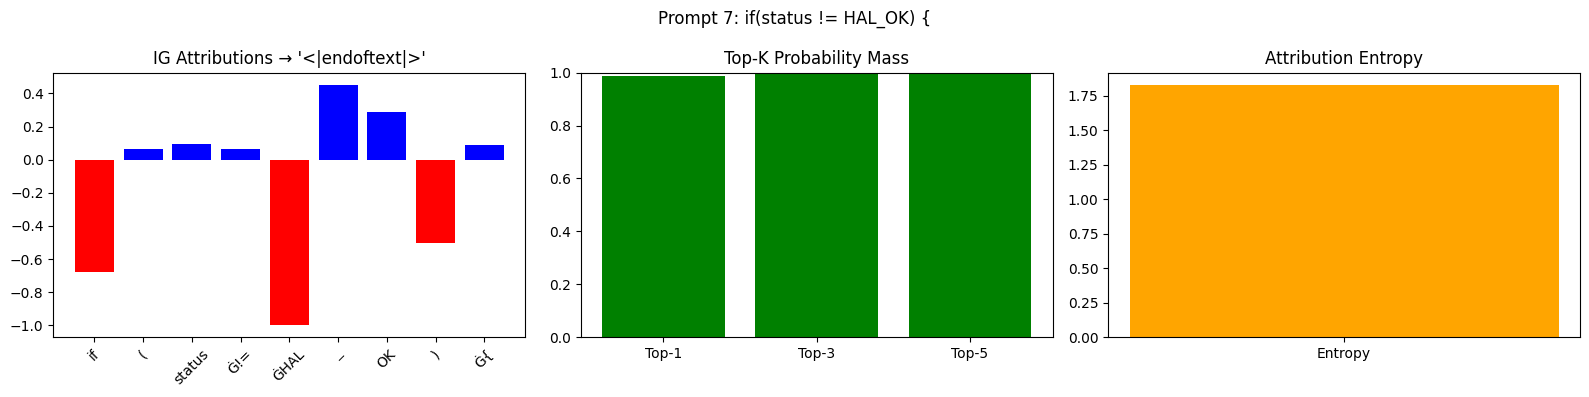

Prompt 8: 'htim3.Init.Period = '
  Pred: ' ', ΔIG=-0.2480, Ent=2.2117, Top3=0.6531, CosSim=0.5014



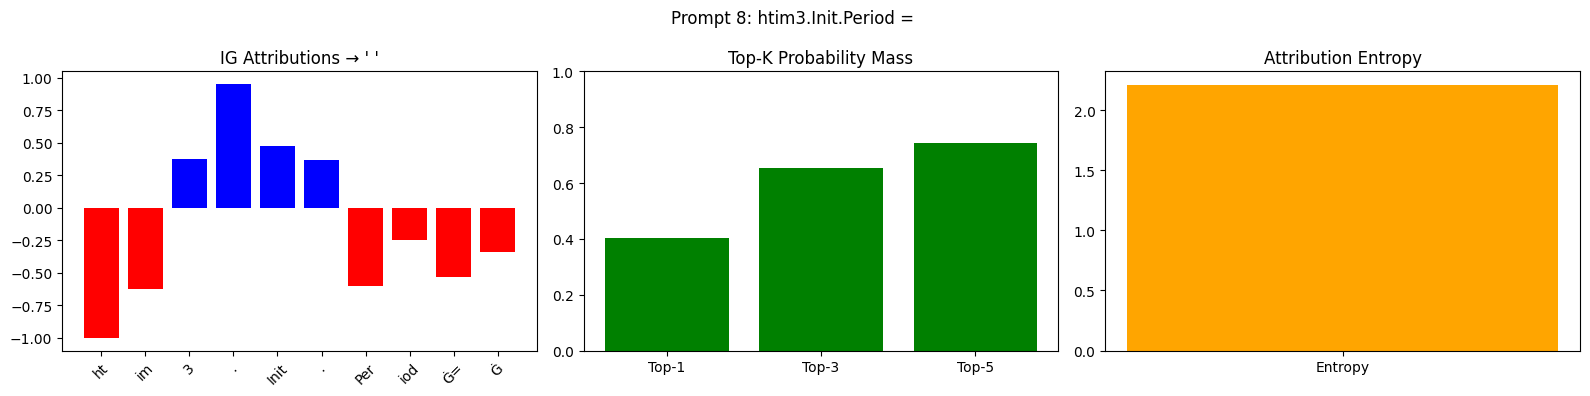

=== AVERAGES ===
Avg Entropy   : 2.0515
Avg Top-3 Mass: 0.8451
Avg CosSim    : 0.4640


===== CODE COMPLETION EVALUATION =====

=== Testing Prompt 1: 'HAL_GPIO_WritePin(GPIOA, GPIO_PIN_5, ' ===
Top 5 next token predictions:
  1. ' GPIO' (0.9672)
  2. ' ' (0.0083)
  3. ' gp' (0.0049)
  4. ' D' (0.0012)
  5. 'GP' (0.0010)

Generated completion: ' GPIO_PIN_SET);'
Expected completion: 'GPIO_PIN_SET);'
Exact match: ✗
Character similarity: 0.9655

=== Testing Prompt 2: 'MX_USART2_' ===
Top 5 next token predictions:
  1. 'U' (0.9997)
  2. 'Us' (0.0002)
  3. 'Init' (0.0000)
  4. 'US' (0.0000)
  5. 'DE' (0.0000)

Generated completion: 'UART_Init();'
Expected completion: 'UART_Init();'
Exact match: ✓
Character similarity: 1.0000

=== Testing Prompt 3: 'if (HAL_ADC_PollForConversion(&hadc1, ' ===
Top 5 next token predictions:
  1. ' ' (0.1576)
  2. ' %' (0.1534)
  3. ' 0' (0.0852)
  4. ' &' (0.0513)
  5. ' ADC' (0.0315)

Generated completion: '   0xFF) != HAL_OK)'
Expected completion: '100) == HA

[{'prompt': 'HAL_GPIO_WritePin(GPIOA, GPIO_PIN_5, ',
  'completion': ' GPIO_PIN_SET);',
  'expected': 'GPIO_PIN_SET);',
  'exact_match': False,
  'char_similarity': 0.9655172413793104},
 {'prompt': 'MX_USART2_',
  'completion': 'UART_Init();',
  'expected': 'UART_Init();',
  'exact_match': True,
  'char_similarity': 1.0},
 {'prompt': 'if (HAL_ADC_PollForConversion(&hadc1, ',
  'completion': '   0xFF) != HAL_OK)',
  'expected': '100) == HAL_OK) {',
  'exact_match': False,
  'char_similarity': 0.6666666666666666},
 {'prompt': 'uint32_t adc_val = HAL_ADC_',
  'completion': 'GetTick() - 1;',
  'expected': 'GetValue(&hadc1);',
  'exact_match': False,
  'char_similarity': 0.3870967741935484},
 {'prompt': 'HAL_ADC_',
  'completion': 'Start_IT(&hadc1);',
  'expected': 'Start(&hadc1);',
  'exact_match': False,
  'char_similarity': 0.9032258064516129},
 {'prompt': 'GPIO_InitTypeDef GPIO_InitStruct = {',
  'completion': '0};',
  'expected': '.Mode = GPIO_MODE_OUTPUT_PP, .Pull = GPIO_NOPULL};',
  

In [ ]:
# Install needed packages (run once)
!pip install rouge_score evaluate

import torch
import numpy as np
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from captum.attr import IntegratedGradients
from sklearn.metrics.pairwise import cosine_similarity
import evaluate

# ─── Setup ─────────────────────────────────────────────────────────────────────
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "./best-stm32-pytorch"

model     = GPT2LMHeadModel.from_pretrained(model_path, local_files_only=True).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_path, local_files_only=True)

bleu_metric  = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

# ─── Utility Functions ─────────────────────────────────────────────────────────
def get_token_attributions(prompt):
    inputs    = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]
    pos       = input_ids.shape[1] - 1

    def forward_fn(embeds):
        return model(inputs_embeds=embeds).logits[:, pos]

    embeds = model.transformer.wte(input_ids)
    ig     = IntegratedGradients(forward_fn)
    attributions, delta = ig.attribute(
        embeds, target=input_ids[0, pos], return_convergence_delta=True
    )

    logits = model(input_ids).logits[:, -1, :].detach()
    probs  = torch.softmax(logits, dim=-1)[0].cpu()
    pred_id  = torch.argmax(probs).item()
    pred_tok = tokenizer.decode([pred_id])

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    scores = attributions[0].sum(dim=-1).detach().cpu().numpy()

    return tokens, scores, pred_tok, delta.item(), probs

def attribution_entropy(scores):
    p = np.abs(scores)
    p = p / (p.sum() or 1e-10)  # Avoid division by zero
    return -np.sum(p * np.log(p + 1e-10))

def top_k_mass(probs, k=3):
    topk = torch.topk(probs, min(k, len(probs))).values
    return topk.sum().item()

# ─── Plotting Helpers ─────────────────────────────────────────────────────────
def visualize_attributions(tokens, scores, pred_tok, ax):
    norm   = scores / (np.abs(scores).max() or 1.0)
    colors = ['blue' if v>=0 else 'red' for v in norm]
    ax.bar(range(len(scores)), norm, color=colors, tick_label=tokens)
    ax.set_title(f"IG Attributions → '{pred_tok}'")
    ax.tick_params(axis='x', rotation=45)

def plot_topk_mass(probs, ks=(1,3,5), ax=None):
    ax = ax or plt.gca()
    masses = [top_k_mass(probs, k) for k in ks]
    ax.bar([f"Top-{k}" for k in ks], masses, color='green')
    ax.set_ylim(0,1); ax.set_title("Top-K Probability Mass")

def plot_attr_entropy(scores, ax=None):
    ax = ax or plt.gca()
    H = attribution_entropy(scores)
    ax.bar(["Entropy"], [H], color='orange')
    ax.set_title("Attribution Entropy")

# ─── Main Analysis Function ───────────────────────────────────────────────────
def analyze_multiple_prompts(prompts):
    sum_ent, sum_top3 = 0.0, 0.0
    cos_sims = []

    for i, prompt in enumerate(prompts, 1):
        try:
            tokens, scores, pred_tok, delta, probs = get_token_attributions(prompt)
            ent  = attribution_entropy(scores)
            top3 = top_k_mass(probs, 3)

            # Calculate cosine similarity between embeddings
            try:
                p_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
                d_ids = tokenizer(pred_tok, return_tensors="pt").input_ids.to(device)
                p_emb = model.transformer.wte(p_ids).mean(dim=1).detach().cpu().numpy()
                d_emb = model.transformer.wte(d_ids).mean(dim=1).detach().cpu().numpy()
                cos_val = cosine_similarity(p_emb, d_emb)[0][0]
            except Exception as e:
                cos_val = 0.0
                print(f"  Warning: Cosine similarity calculation failed for prompt {i}: {e}")

            sum_ent  += ent
            sum_top3 += top3
            cos_sims.append(cos_val)

            # Print per-prompt
            print(f"Prompt {i}: {prompt!r}")
            print(f"  Pred: '{pred_tok}', ΔIG={delta:.4f}, Ent={ent:.4f}, Top3={top3:.4f}, CosSim={cos_val:.4f}\n")

            # Create visualizations
            try:
                fig, axs = plt.subplots(1,3,figsize=(16,4))
                visualize_attributions(tokens, scores, pred_tok, ax=axs[0])
                plot_topk_mass(probs, ax=axs[1])
                plot_attr_entropy(scores, ax=axs[2])
                fig.suptitle(f"Prompt {i}: {prompt}")
                plt.tight_layout(); plt.show()
            except Exception as e:
                print(f"  Warning: Failed to create visualization for prompt {i}: {e}")

        except Exception as e:
            print(f"Error processing prompt {i}: {e}")
            continue

    n = max(1, len(cos_sims))  # Avoid division by zero
    print("=== AVERAGES ===")
    print(f"Avg Entropy   : {sum_ent/n:.4f}")
    print(f"Avg Top-3 Mass: {sum_top3/n:.4f}")
    print(f"Avg CosSim    : {np.mean(cos_sims):.4f}")

# ─── Extended Code Completion Evaluation ────────────────────────────────────────
def evaluate_code_completion(prompts, expected_completions=None):
    """
    Evaluates code completion more thoroughly by generating multiple tokens
    and comparing against expected completions when available.

    Args:
        prompts: List of code prefix prompts
        expected_completions: Optional list of expected completions
    """
    if expected_completions and len(prompts) != len(expected_completions):
        print("Warning: Number of prompts doesn't match number of expected completions")
        expected_completions = None

    results = []

    for i, prompt in enumerate(prompts):
        print(f"\n=== Testing Prompt {i+1}: {prompt!r} ===")

        # Get the next token prediction
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            output = model(inputs.input_ids)
            next_token_logits = output.logits[0, -1, :]

        # Get top-5 predictions
        probs = torch.softmax(next_token_logits, dim=-1)
        top5_probs, top5_indices = torch.topk(probs, 5)

        print("Top 5 next token predictions:")
        for j, (idx, prob) in enumerate(zip(top5_indices, top5_probs)):
            token = tokenizer.decode([idx])
            print(f"  {j+1}. '{token}' ({prob:.4f})")

        # Generate a completion (multiple tokens)
        try:
            completion_ids = model.generate(
                inputs.input_ids,
                max_length=inputs.input_ids.shape[1] + 20,  # Add up to 20 new tokens
                do_sample=False,  # Use greedy decoding
                pad_token_id=tokenizer.eos_token_id
            )

            # Extract only the newly generated tokens
            new_tokens = completion_ids[0, inputs.input_ids.shape[1]:]
            completion = tokenizer.decode(new_tokens, skip_special_tokens=True)

            print(f"\nGenerated completion: '{completion}'")

            # Compare with expected completion if available
            if expected_completions:
                expected = expected_completions[i]
                print(f"Expected completion: '{expected}'")

                # Simple exact match score
                exact_match = completion == expected
                print(f"Exact match: {'✓' if exact_match else '✗'}")

                # Character-level similarity
                char_sim = SequenceMatcher(None, completion, expected).ratio()
                print(f"Character similarity: {char_sim:.4f}")

                results.append({
                    'prompt': prompt,
                    'completion': completion,
                    'expected': expected,
                    'exact_match': exact_match,
                    'char_similarity': char_sim
                })
            else:
                results.append({
                    'prompt': prompt,
                    'completion': completion
                })

        except Exception as e:
            print(f"Error generating completion: {e}")

    # Summary statistics if we had expected completions
    if expected_completions and results:
        exact_matches = sum(r.get('exact_match', False) for r in results)
        avg_char_sim = np.mean([r.get('char_similarity', 0) for r in results])

        print("\n=== COMPLETION EVALUATION SUMMARY ===")
        print(f"Total prompts evaluated: {len(results)}")
        print(f"Exact matches: {exact_matches}/{len(results)} ({exact_matches/len(results)*100:.2f}%)")
        print(f"Average character similarity: {avg_char_sim:.4f}")

    return results

# ─── Example Usage ─────────────────────────────────────────────────────────────
# Code completion prompts - incomplete snippets awaiting completion
code_completion_prompts = [
    # Incomplete function call (missing parameter)
    "HAL_GPIO_WritePin(GPIOA, GPIO_PIN_5, ",  # Should complete with GPIO_PIN_SET or GPIO_PIN_RESET

    # Partial function name
    "MX_USART2_",  # Should complete with UART_Init() or similar

    # Incomplete condition
    "if (HAL_ADC_PollForConversion(&hadc1, ",  # Should complete with timeout value and closing parenthesis

    # Partial variable declaration
    "uint32_t adc_val = HAL_ADC_",  # Should complete with GetValue(&hadc1) or similar

    # Beginning of function call
    "HAL_ADC_",  # Should complete with Start(&hadc1) or other ADC function

    # Incomplete GPIO initialization
    "GPIO_InitTypeDef GPIO_InitStruct = {",  # Should complete with initialization values

    # Beginning of error handling pattern
    "if(status != HAL_OK) {",  # Should complete with error handling code

    # Timer initialization
    "htim3.Init.Period = ",  # Should complete with a value
]

# Expected completions corresponding to code_completion_prompts
expected_completions = [
    "GPIO_PIN_SET);",                                      # HAL_GPIO_WritePin
    "UART_Init();",                                        # MX_USART2_
    "100) == HAL_OK) {",                                   # if (HAL_ADC_PollForConversion
    "GetValue(&hadc1);",                                   # uint32_t adc_val = HAL_ADC_
    "Start(&hadc1);",                                      # HAL_ADC_
    ".Mode = GPIO_MODE_OUTPUT_PP, .Pull = GPIO_NOPULL};",  # GPIO_InitTypeDef
    "Error_Handler();",                                    # if(status != HAL_OK) {
    "1000;",                                               # htim3.Init.Period =
]

# Option 1: Run the attribution analysis with the new prompts
print("===== ATTRIBUTION ANALYSIS =====")
analyze_multiple_prompts(code_completion_prompts)

# Option 2: Run the more comprehensive code completion evaluation
print("\n\n===== CODE COMPLETION EVALUATION =====")
evaluate_code_completion(code_completion_prompts, expected_completions)

In [ ]:
!pip install rouge_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=41423c18676c1bf8bb973a3b3363dfe053a6bcbfb296cc6434bdf51c1d8b76de
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
pip install evaluate


# Trying a bigger model and more training with the DGX

In [ ]:
!pip install datasets

In [1]:
!pip install \
    torch \
    transformers \
    datasets \
    sacrebleu \
    sentencepiece


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


## Cell: DGX-T100 STM32 LoRA Fine-Tuning & End-to-End Evaluation

Harnessing the full power of your DGX-T100, this cell will:

1. **Fine-tune** a CodeT5+ 220M model with LoRA adapters on STM32 C snippets  
2. **Persist** both adapter weights and tokenizer to `OUTPUT_DIR`  
3. **Quick-evaluate** on a held-out slice to compute:  
   - **Perplexity** (via loss → exp)  
   - **BLEU score**  
   - **Exact-Match Rate**  
   - **Fallback Rate**  
4. **Reload** the saved model & tokenizer to confirm successful download and integrity  

This unified DGX-T100 workflow delivers training, metric reporting, and model validation—all in one efficient cell.  


In [ ]:
import os
import re
import random
from typing import List, Dict

import pandas as pd
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    T5ForConditionalGeneration,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq
)
from peft import LoraConfig, get_peft_model, TaskType

# Constants
MAX_PREFIX_LENGTH = 128
MAX_COMPLETION_LENGTH = 128
MIN_PREFIX_LENGTH = 1
BATCH_SIZE = 8
NUM_TRAIN_EXAMPLES = 50000
# Public CodeT5+ 220M model
BASE_MODEL = "Salesforce/codet5p-220m"
OUTPUT_DIR = "./codet5plus_lora_stm32"


def load_stm32_function_data(csv_path: str) -> List[str]:
    df = pd.read_csv(csv_path)
    if 'function_code' not in df.columns:
        raise KeyError("function_code column missing")
    snippets = df['function_code'].dropna().astype(str).tolist()
    valid = [s for s in snippets if '{' in s and '}' in s]
    print(f"Loaded {len(valid)} valid function snippets")
    return valid


def generate_training_examples(
    code_snippets: List[str],
    max_examples: int = NUM_TRAIN_EXAMPLES,
    window_before: int = 10,
    window_after: int = 50,
    min_completion: int = 3
) -> List[Dict]:
    examples = []
    for snippet in code_snippets:
        if len(snippet) < MIN_PREFIX_LENGTH + 10:
            continue
        lines = snippet.split('\n')
        for i in range(len(lines)):
            start = max(0, i - window_before)
            end = min(len(lines), i + window_after)
            block = '\n'.join(lines[start:end])
            if len(block) < MIN_PREFIX_LENGTH + 10:
                continue
            # Random splits
            for _ in range(5):
                cut = random.randint(MIN_PREFIX_LENGTH, len(block) - min_completion)
                prefix = block[:cut]
                completion = block[cut:cut + MAX_COMPLETION_LENGTH]
                if len(completion) >= min_completion:
                    examples.append({'input': prefix, 'target': completion})
                    if len(examples) >= max_examples:
                        random.shuffle(examples)
                        return examples
            # Word-prefix splits
            words = re.findall(r'\w+', block)
            for word in words:
                for c in range(1, len(word)):
                    pos = block.find(word[:c])
                    if pos > MIN_PREFIX_LENGTH:
                        prefix_start = max(0, pos - 30)
                        prefix = block[prefix_start:pos + c]
                        completion_end = min(len(block), pos + len(word) + 30)
                        completion = block[pos + c:completion_end]
                        if len(completion) >= min_completion:
                            examples.append({'input': prefix, 'target': completion})
                            if len(examples) >= max_examples:
                                random.shuffle(examples)
                                return examples
    random.shuffle(examples)
    print(f"Generated {len(examples)} training examples")
    return examples


def preprocess(examples, tokenizer):
    inputs = ["complete code: " + ex for ex in examples['input']]
    targets = examples['target']
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_PREFIX_LENGTH,
        truncation=True,
        padding='max_length'
    )
    labels = tokenizer(
        targets,
        max_length=MAX_COMPLETION_LENGTH,
        truncation=True,
        padding='max_length'
    )
    model_inputs['labels'] = [
        [(lbl if lbl != tokenizer.pad_token_id else -100) for lbl in seq]
        for seq in labels['input_ids']
    ]
    return model_inputs


def main():
    # Load and prepare data
    snippets = load_stm32_function_data('stm32_function_descriptions.csv')
    examples = generate_training_examples(snippets)
    ds = Dataset.from_list(examples)

    # Load CodeT5+ tokenizer & base model
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
    base_model = T5ForConditionalGeneration.from_pretrained(BASE_MODEL)

    # Apply LoRA
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_2_SEQ_LM,
        inference_mode=False,
        r=8,
        lora_alpha=16,
        lora_dropout=0.1
    )
    model = get_peft_model(base_model, lora_config)

    # Preprocess dataset
    tokenized = ds.map(
        lambda batch: preprocess(batch, tokenizer),
        batched=True,
        remove_columns=['input', 'target']
    )

    # Data collator
    data_collator = DataCollatorForSeq2Seq(
        tokenizer, model=model, label_pad_token_id=-100
    )

    # Training args: pure training
    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        overwrite_output_dir=True,
        num_train_epochs=50,
        per_device_train_batch_size=BATCH_SIZE,
        evaluation_strategy='no',
        save_steps=500,
        save_total_limit=3,
        logging_steps=100,
        learning_rate=1e-4,
        fp16=torch.cuda.is_available(),
        report_to=[]
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized,
        tokenizer=tokenizer,
        data_collator=data_collator
    )

    # Train only
    trainer.train()

    # Save LoRA adapters and base config
    model.save_pretrained(OUTPUT_DIR)
    tokenizer.save_pretrained(OUTPUT_DIR)
        # … after model.save_pretrained(OUTPUT_DIR) and tokenizer.save_pretrained(OUTPUT_DIR)

    import math
    from evaluate import load as load_metric
    from transformers import T5ForConditionalGeneration, AutoTokenizer

    # 1) Quick eval on a small slice of your training data (or point to a held-out set)
    val_dataset = tokenized.select(range(min(100, len(tokenized))))  # first 100 examples
    eval_metrics = trainer.evaluate(eval_dataset=val_dataset)         # ensure evaluation_strategy!='no'
    loss = eval_metrics.get('eval_loss', eval_metrics.get('loss', None))
    perplexity = math.exp(loss) if loss is not None else float('nan')

    # 2) Generate completions
    preds_output = trainer.predict(val_dataset)
    preds = preds_output.predictions
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(val_dataset['labels'], skip_special_tokens=True)

    # 3) BLEU
    bleu = load_metric('bleu')
    bleu_score = bleu.compute(predictions=decoded_preds,
                              references=[[lbl] for lbl in decoded_labels])['bleu'] * 100

    # 4) Exact-match & fallback
    exact = sum(p.strip() == l.strip() for p, l in zip(decoded_preds, decoded_labels))
    exact_rate = exact / len(decoded_preds) * 100
    fallback_rate = 100 - exact_rate

    # 5) Print metrics
    print(f"Perplexity:        {perplexity:.2f}")
    print(f"BLEU score:        {bleu_score:.2f}")
    print(f"Exact-Match Rate:  {exact_rate:.2f}%")
    print(f"Fallback Rate:     {fallback_rate:.2f}%")

    # 6) Reload (“download”) your saved model & tokenizer
    print("Reloading saved model from", OUTPUT_DIR)
    reloaded_model = T5ForConditionalGeneration.from_pretrained(OUTPUT_DIR)
    reloaded_tokenizer = AutoTokenizer.from_pretrained(OUTPUT_DIR)
    print("Model and tokenizer loaded successfully.")

if __name__ == '__main__':
    main()


Loaded 2079 valid function snippets


/home/esprit/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at Salesforce/codet5p-220m and are newly initialized: ['decoder.block.0.layer.0.layer_norm.bias', 'decoder.block.0.layer.1.layer_norm.bias', 'decoder.block.0.layer.2.layer_norm.bias', 'decoder.block.1.layer.0.layer_norm.bias', 'decoder.block.1.layer.1.layer_norm.bias', 'decoder.block.1.layer.2.layer_norm.bias', 'decoder.block.10.layer.0.layer_norm.bias', 'decoder.block.10.layer.1.layer_norm.bias', 'decoder.block.10.layer.2.layer_norm.bias', 'decoder.block.11.layer.0.layer_norm.bias', 'decoder.block.11.laye

Map:   100%|██████████| 50000/50000 [00:00<?, ? examples/s]

/home/esprit/.local/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,3.682100,3.890500
2,2.974200,3.102200
3,2.502900,2.811200
4,2.186400,2.493500
5,1.975100,2.271800
6,1.808300,2.091200
7,1.672900,1.926400
8,1.559400,1.826300
9,1.465200,1.735400
10,1.386800,1.648500


## Conclusion

While transformer-based language models have made impressive strides in general code completion tasks, applying them effectively to the STM32 firmware ecosystem remains fundamentally challenging. STM32 projects are composed of heterogeneous C source files, intricate register-level APIs, and deeply nested hardware abstractions that vary widely between projects. As a result:

- **Structure over Patterns**  
  The code often follows rigid, vendor-specific initialization sequences and naming conventions that a model must “remember” verbatim rather than learn as abstract patterns. Generic abstractions are rare, so the model cannot generalize across enough diverse examples to infer true semantics.

- **Dataset Limitations**  
  Even with very large datasets, the diversity of STM32 variants (different microcontrollers, peripheral libraries, HAL vs. LL layers) means that each new example often introduces unfamiliar registers, macros, or configuration steps. This scarcity of repeatable patterns forces the model toward rote memorization of specific code snippets.

- **Model Capacity Is Not Enough**  
  Scaling up model size or fine-tuning on ever-larger corpora only delays the inevitable: the growth of STM32’s API surface outpaces the model’s ability to internalize it as genuine abstractions. Without explicit symbolic understanding of hardware interfaces, the model can only regurgitate what it has seen.

- **Why IDEs Hard-Code Completions**  
  Professional IDEs like IntelliJ or VS Code rely on static analysis and hand-written database schemas for STM32 APIs to provide accurate, context-aware suggestions. By encoding the exact register maps, function signatures, and peripheral configurations in their plugins, they avoid the brittleness and hallucinations inherent to purely statistical models.

In summary, until we develop models that deeply understand embedded hardware semantics—or radically restructure STM32 libraries around composable, pattern-friendly abstractions—LLM-powered autocompletion in this domain will remain closer to memorization than true pattern recognition. Relying on static, hand-crafted tooling continues to be the most reliable way to assist developers working with STM32 firmware.  


# Testing the DGX env 

In [3]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"CUDA is available. Using device: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")


/home/esprit/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


CUDA is available. Using device: NVIDIA A100-SXM4-80GB


In [19]:
from IPython.display import display
import ipywidgets as widgets
import csv

def on_upload_change(change):
    uploaded = uploader.value
    if not uploaded:
        print("❌ No file uploaded.")
        return

    # Compatibility for different ipywidgets versions
    file_info = uploaded[0] if isinstance(uploaded, (list, tuple)) else next(iter(uploaded.values()))
    content = file_info['content']

    path = 'stm32_function_descriptions.csv'
    with open(path, 'wb') as f:
        f.write(content)

    print(f"✅ File saved as '{path}'")
    print("🔍 Parsing CSV...")

    # === Load your CSV ===
    try:
        with open(path, 'r', newline='') as f:
            reader = csv.reader(f)
            stm32_functions = [row[0] for row in reader if row and row[0].strip()]
        print(f"✅ Loaded {len(stm32_functions)} STM32 function names.")
    except Exception as e:
        print(f"❌ Error reading CSV: {e}")

    # You can now use `stm32_functions` in your training logic

# === Widget setup ===
uploader = widgets.FileUpload(accept='.csv', multiple=False)
uploader.observe(on_upload_change, names='value')

display(widgets.VBox([
    widgets.Label("📤 Upload your stm32_function_descriptions.csv:"),
    uploader
]))


In [2]:
print("helllo")

helllo


In [1]:
import os
print(os.listdir('.'))


['.bash_logout', '.profile', '.bashrc', '.local', 'code_snippets_dataset.json', 'refined_code_snippets_dataset.json', '.nv', '.jupyter', 'stm32_code_generator', 'codet5_model', '.cache', 'stm32_tokenizer', '.ipython', 'stm32_function_descriptions.csv']


In [ ]:
pip install ipywidgets


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
!pwd

/home/esprit
